# Liquid Foam Stress Relaxation

Fit liquid foam relaxation data.

**Data:** examples/data/pyRheo/shaving_foam/stressrelaxation_liquidfoam_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-07 17:33:22,021:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'shaving_foam'
df = load_tab_file(DATA_DIR / 'stressrelaxation_liquidfoam_data.csv')
t = df.iloc[:,0].to_numpy()
G = df.iloc[:,1].to_numpy()


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, G)

fm = FractionalMaxwellModel()
fm.fit(t, G, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(G, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.379435s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=1.379s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.351049s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=0.351s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.825043s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=3.853320e+02 | time=0.825s | final_gradient_norm=0.20374884693319067


Element minimization: early termination at n_modes=3 (R²=0.999674 < threshold=0.999745)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.323875s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.610186e+05 | time=1.324s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9998299348748985, 'fm_r2': -19635.53943933752}


## Plot relaxation fits

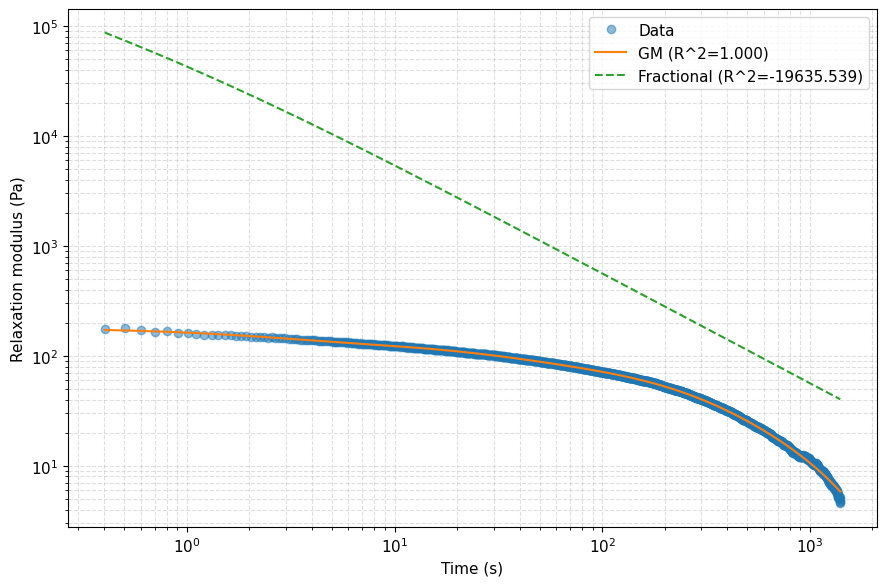

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, G, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.356537s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=0.357s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.442023s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=2.011973e+02 | time=0.442s | final_gradient_norm=3.448524376493388


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.237264s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=3.853320e+02 | time=0.237s | final_gradient_norm=0.20374884693319067


Element minimization: early termination at n_modes=3 (R²=0.999674 < threshold=0.999745)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.704224s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.610186e+05 | time=0.704s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 1.0), ('fm', -19635.539)]


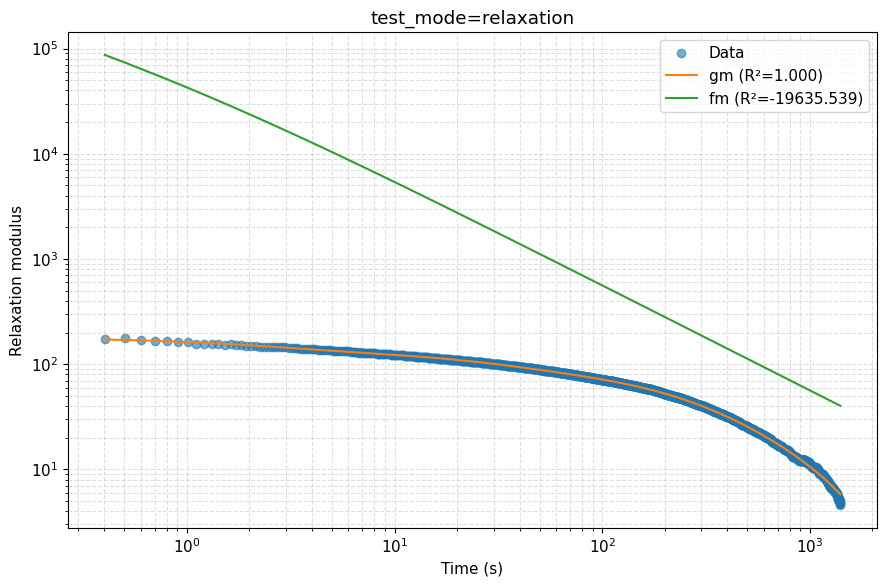

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<55:55,  1.19it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 52/4000 [00:00<00:54, 72.75it/s, 767 steps of size 2.97e-04. acc. prob=0.71]

warmup:   2%|▏         | 77/4000 [00:01<00:53, 73.52it/s, 255 steps of size 5.29e-04. acc. prob=0.74]

warmup:   2%|▏         | 94/4000 [00:01<00:54, 71.58it/s, 127 steps of size 5.11e-04. acc. prob=0.74]

warmup:   3%|▎         | 107/4000 [00:01<01:03, 61.41it/s, 1023 steps of size 1.42e-02. acc. prob=0.75]

warmup:   3%|▎         | 117/4000 [00:02<01:06, 58.39it/s, 3 steps of size 2.08e-03. acc. prob=0.75]   

warmup:   3%|▎         | 126/4000 [00:02<01:11, 54.43it/s, 511 steps of size 1.01e-02. acc. prob=0.76]

warmup:   3%|▎         | 133/4000 [00:02<01:15, 51.52it/s, 767 steps of size 1.47e-02. acc. prob=0.76]

warmup:   3%|▎         | 139/4000 [00:02<01:20, 48.17it/s, 1023 steps of size 1.81e-02. acc. prob=0.76]

warmup:   4%|▎         | 145/4000 [00:02<01:22, 46.68it/s, 1023 steps of size 2.55e-02. acc. prob=0.77]

warmup:   4%|▍         | 156/4000 [00:02<01:07, 57.04it/s, 447 steps of size 1.82e-02. acc. prob=0.76] 

warmup:   4%|▍         | 164/4000 [00:02<01:02, 60.94it/s, 1023 steps of size 4.03e-03. acc. prob=0.76]

warmup:   4%|▍         | 172/4000 [00:03<00:59, 63.92it/s, 255 steps of size 5.73e-03. acc. prob=0.76] 

warmup:   4%|▍         | 179/4000 [00:03<01:00, 62.77it/s, 31 steps of size 1.77e-02. acc. prob=0.77] 

warmup:   5%|▍         | 187/4000 [00:03<00:59, 64.23it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:   5%|▍         | 196/4000 [00:03<00:55, 68.02it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:   5%|▌         | 203/4000 [00:03<00:57, 65.86it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:   5%|▌         | 213/4000 [00:03<00:51, 74.15it/s, 127 steps of size 2.81e-02. acc. prob=0.77]

warmup:   6%|▌         | 225/4000 [00:03<00:43, 85.85it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:   6%|▌         | 234/4000 [00:03<00:49, 76.43it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:   6%|▌         | 245/4000 [00:03<00:44, 84.78it/s, 47 steps of size 1.17e-02. acc. prob=0.77] 

warmup:   6%|▋         | 254/4000 [00:04<00:43, 86.11it/s, 1023 steps of size 5.37e-03. acc. prob=0.77]

warmup:   7%|▋         | 264/4000 [00:04<00:42, 88.76it/s, 127 steps of size 1.61e-02. acc. prob=0.77] 

warmup:   7%|▋         | 274/4000 [00:04<00:46, 80.59it/s, 511 steps of size 3.06e-02. acc. prob=0.78]

warmup:   7%|▋         | 283/4000 [00:04<00:46, 80.61it/s, 255 steps of size 1.33e-02. acc. prob=0.77]

warmup:   7%|▋         | 296/4000 [00:04<00:41, 89.06it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:   8%|▊         | 307/4000 [00:04<00:40, 91.64it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:   8%|▊         | 317/4000 [00:04<00:39, 93.29it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:   8%|▊         | 327/4000 [00:04<00:41, 88.44it/s, 127 steps of size 2.03e-02. acc. prob=0.78]

warmup:   8%|▊         | 339/4000 [00:05<00:37, 96.39it/s, 127 steps of size 2.77e-02. acc. prob=0.78]

warmup:   9%|▉         | 350/4000 [00:05<00:36, 98.95it/s, 767 steps of size 1.52e-02. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:05<00:34, 105.01it/s, 383 steps of size 9.21e-03. acc. prob=0.78]

warmup:   9%|▉         | 375/4000 [00:05<00:33, 108.40it/s, 127 steps of size 1.35e-02. acc. prob=0.78]

warmup:  10%|▉         | 387/4000 [00:05<00:32, 111.64it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  10%|█         | 400/4000 [00:05<00:30, 116.76it/s, 127 steps of size 1.73e-02. acc. prob=0.78]

warmup:  10%|█         | 412/4000 [00:05<00:34, 103.76it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [00:05<00:32, 108.91it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [00:05<00:32, 109.37it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [00:06<00:32, 108.88it/s, 319 steps of size 2.12e-02. acc. prob=0.78]

warmup:  12%|█▏        | 461/4000 [00:06<00:37, 94.12it/s, 1023 steps of size 6.06e-03. acc. prob=0.78]

warmup:  12%|█▏        | 471/4000 [00:06<00:45, 77.10it/s, 1023 steps of size 1.08e-02. acc. prob=0.78]

warmup:  12%|█▏        | 481/4000 [00:06<00:43, 81.58it/s, 127 steps of size 2.46e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 490/4000 [00:06<00:42, 82.78it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  13%|█▎        | 502/4000 [00:06<00:38, 90.80it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  13%|█▎        | 513/4000 [00:06<00:37, 93.86it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  13%|█▎        | 523/4000 [00:06<00:37, 92.00it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  13%|█▎        | 533/4000 [00:07<00:37, 91.76it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [00:07<00:33, 102.85it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  14%|█▍        | 563/4000 [00:07<00:29, 117.86it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  14%|█▍        | 578/4000 [00:07<00:27, 124.42it/s, 255 steps of size 3.20e-02. acc. prob=0.78]

warmup:  15%|█▍        | 591/4000 [00:07<00:27, 123.11it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  15%|█▌        | 604/4000 [00:07<00:28, 121.03it/s, 87 steps of size 2.46e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 617/4000 [00:07<00:28, 120.80it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  16%|█▌        | 630/4000 [00:07<00:29, 114.80it/s, 415 steps of size 1.81e-02. acc. prob=0.78]

warmup:  16%|█▌        | 642/4000 [00:07<00:30, 110.13it/s, 127 steps of size 1.74e-02. acc. prob=0.79]

warmup:  16%|█▋        | 654/4000 [00:08<00:30, 109.95it/s, 255 steps of size 2.39e-02. acc. prob=0.79]

warmup:  17%|█▋        | 668/4000 [00:08<00:28, 115.92it/s, 255 steps of size 1.81e-02. acc. prob=0.79]

warmup:  17%|█▋        | 680/4000 [00:08<00:28, 116.05it/s, 127 steps of size 2.43e-02. acc. prob=0.79]

warmup:  17%|█▋        | 693/4000 [00:08<00:28, 116.72it/s, 319 steps of size 1.71e-02. acc. prob=0.79]

warmup:  18%|█▊        | 705/4000 [00:08<00:28, 116.40it/s, 255 steps of size 1.60e-02. acc. prob=0.79]

warmup:  18%|█▊        | 718/4000 [00:08<00:27, 117.87it/s, 255 steps of size 2.39e-02. acc. prob=0.79]

warmup:  18%|█▊        | 732/4000 [00:08<00:26, 122.10it/s, 255 steps of size 1.93e-02. acc. prob=0.79]

warmup:  19%|█▊        | 745/4000 [00:08<00:28, 112.37it/s, 511 steps of size 1.44e-02. acc. prob=0.79]

warmup:  19%|█▉        | 759/4000 [00:08<00:28, 115.54it/s, 511 steps of size 2.71e-02. acc. prob=0.79]

warmup:  19%|█▉        | 776/4000 [00:09<00:25, 128.40it/s, 127 steps of size 1.79e-02. acc. prob=0.79]

warmup:  20%|█▉        | 790/4000 [00:09<00:25, 125.83it/s, 255 steps of size 2.76e-02. acc. prob=0.79]

warmup:  20%|██        | 803/4000 [00:09<00:25, 124.43it/s, 255 steps of size 1.52e-02. acc. prob=0.79]

warmup:  20%|██        | 816/4000 [00:09<00:26, 118.87it/s, 383 steps of size 2.28e-02. acc. prob=0.79]

warmup:  21%|██        | 828/4000 [00:09<00:27, 115.78it/s, 255 steps of size 1.39e-02. acc. prob=0.79]

warmup:  21%|██        | 840/4000 [00:09<00:31, 100.57it/s, 383 steps of size 2.03e-02. acc. prob=0.79]

warmup:  21%|██▏       | 854/4000 [00:09<00:28, 108.83it/s, 255 steps of size 1.18e-02. acc. prob=0.79]

warmup:  22%|██▏       | 867/4000 [00:09<00:27, 112.89it/s, 255 steps of size 1.89e-02. acc. prob=0.79]

warmup:  22%|██▏       | 881/4000 [00:09<00:26, 117.61it/s, 255 steps of size 1.29e-02. acc. prob=0.79]

warmup:  22%|██▏       | 896/4000 [00:10<00:24, 125.85it/s, 255 steps of size 1.51e-02. acc. prob=0.79]

warmup:  23%|██▎       | 909/4000 [00:10<00:26, 114.90it/s, 255 steps of size 1.89e-02. acc. prob=0.79]

warmup:  23%|██▎       | 922/4000 [00:10<00:26, 117.68it/s, 255 steps of size 1.25e-02. acc. prob=0.79]

warmup:  23%|██▎       | 937/4000 [00:10<00:24, 126.34it/s, 255 steps of size 1.84e-02. acc. prob=0.79]

warmup:  24%|██▍       | 950/4000 [00:10<00:24, 126.66it/s, 255 steps of size 2.37e-02. acc. prob=0.79]

warmup:  24%|██▍       | 963/4000 [00:10<00:24, 122.30it/s, 1023 steps of size 8.83e-03. acc. prob=0.79]

warmup:  24%|██▍       | 976/4000 [00:10<00:29, 103.79it/s, 5 steps of size 3.53e-03. acc. prob=0.79]   

warmup:  25%|██▍       | 987/4000 [00:10<00:34, 86.83it/s, 511 steps of size 2.11e-02. acc. prob=0.79]

warmup:  25%|██▍       | 997/4000 [00:11<00:33, 89.16it/s, 255 steps of size 1.01e-02. acc. prob=0.79]

sample:  25%|██▌       | 1007/4000 [00:11<00:36, 83.05it/s, 511 steps of size 1.22e-02. acc. prob=0.96]

sample:  25%|██▌       | 1016/4000 [00:11<00:37, 79.59it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▌       | 1025/4000 [00:11<00:36, 80.45it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▌       | 1035/4000 [00:11<00:35, 84.45it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  26%|██▌       | 1044/4000 [00:11<00:34, 84.84it/s, 511 steps of size 1.22e-02. acc. prob=0.96]

sample:  26%|██▋       | 1054/4000 [00:11<00:33, 88.93it/s, 511 steps of size 1.22e-02. acc. prob=0.95]

sample:  27%|██▋       | 1064/4000 [00:11<00:33, 87.48it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  27%|██▋       | 1074/4000 [00:11<00:32, 90.37it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  27%|██▋       | 1084/4000 [00:12<00:33, 86.47it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  27%|██▋       | 1094/4000 [00:12<00:32, 89.83it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1104/4000 [00:12<00:31, 91.69it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1114/4000 [00:12<00:33, 86.26it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1124/4000 [00:12<00:32, 89.77it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  28%|██▊       | 1134/4000 [00:12<00:31, 90.82it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  29%|██▊       | 1144/4000 [00:12<00:33, 86.46it/s, 511 steps of size 1.22e-02. acc. prob=0.93]

sample:  29%|██▉       | 1153/4000 [00:12<00:34, 82.95it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  29%|██▉       | 1162/4000 [00:13<00:36, 78.43it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  29%|██▉       | 1171/4000 [00:13<00:35, 78.67it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  29%|██▉       | 1179/4000 [00:13<00:35, 78.85it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|██▉       | 1187/4000 [00:13<00:35, 78.38it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|██▉       | 1195/4000 [00:13<00:37, 74.69it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|███       | 1203/4000 [00:13<00:36, 75.98it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  30%|███       | 1212/4000 [00:13<00:34, 79.91it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1221/4000 [00:13<00:35, 78.34it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1229/4000 [00:13<00:35, 77.77it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1237/4000 [00:14<00:36, 75.90it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███       | 1245/4000 [00:14<00:35, 76.72it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  31%|███▏      | 1254/4000 [00:14<00:35, 77.10it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1262/4000 [00:14<00:36, 75.53it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1270/4000 [00:14<00:36, 74.79it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1278/4000 [00:14<00:36, 75.09it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1286/4000 [00:14<00:35, 76.25it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  32%|███▏      | 1294/4000 [00:14<00:37, 72.33it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1307/4000 [00:14<00:30, 87.86it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1316/4000 [00:14<00:30, 87.03it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1326/4000 [00:15<00:30, 86.55it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  33%|███▎      | 1335/4000 [00:15<00:30, 86.34it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▎      | 1344/4000 [00:15<00:30, 87.21it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▍      | 1353/4000 [00:15<00:30, 87.32it/s, 95 steps of size 1.22e-02. acc. prob=0.94] 

sample:  34%|███▍      | 1362/4000 [00:15<00:35, 73.65it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▍      | 1370/4000 [00:15<00:38, 68.53it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  34%|███▍      | 1379/4000 [00:15<00:36, 72.55it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▍      | 1387/4000 [00:15<00:38, 68.01it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▍      | 1395/4000 [00:16<00:38, 68.38it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▌      | 1407/4000 [00:16<00:32, 79.93it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  35%|███▌      | 1416/4000 [00:16<00:34, 73.91it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▌      | 1424/4000 [00:16<00:35, 73.28it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▌      | 1434/4000 [00:16<00:32, 79.44it/s, 319 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▌      | 1443/4000 [00:16<00:31, 80.21it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  36%|███▋      | 1452/4000 [00:16<00:32, 77.47it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1461/4000 [00:16<00:32, 78.24it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1470/4000 [00:16<00:31, 81.37it/s, 3 steps of size 1.22e-02. acc. prob=0.94]  

sample:  37%|███▋      | 1479/4000 [00:17<00:30, 81.60it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1488/4000 [00:17<00:30, 81.43it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  37%|███▋      | 1499/4000 [00:17<00:28, 86.35it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1509/4000 [00:17<00:27, 88.98it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1518/4000 [00:17<00:29, 83.90it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1527/4000 [00:17<00:29, 83.10it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  38%|███▊      | 1536/4000 [00:17<00:31, 77.28it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▊      | 1544/4000 [00:17<00:32, 74.67it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1552/4000 [00:18<00:32, 74.95it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1560/4000 [00:18<00:32, 76.09it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1568/4000 [00:18<00:34, 71.06it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  39%|███▉      | 1577/4000 [00:18<00:33, 73.01it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|███▉      | 1585/4000 [00:18<00:33, 72.61it/s, 95 steps of size 1.22e-02. acc. prob=0.94] 

sample:  40%|███▉      | 1595/4000 [00:18<00:31, 77.06it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|████      | 1603/4000 [00:18<00:31, 76.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  40%|████      | 1612/4000 [00:18<00:29, 79.86it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████      | 1621/4000 [00:18<00:31, 74.99it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████      | 1632/4000 [00:19<00:28, 82.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████      | 1641/4000 [00:19<00:31, 75.75it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████▏     | 1650/4000 [00:19<00:29, 79.32it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  41%|████▏     | 1659/4000 [00:19<00:29, 78.51it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1667/4000 [00:19<00:30, 76.76it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1676/4000 [00:19<00:29, 78.99it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1685/4000 [00:19<00:28, 80.63it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  42%|████▏     | 1694/4000 [00:19<00:28, 79.95it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1703/4000 [00:19<00:29, 78.06it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1711/4000 [00:20<00:30, 74.06it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1719/4000 [00:20<00:30, 74.33it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1729/4000 [00:20<00:28, 80.83it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  43%|████▎     | 1738/4000 [00:20<00:28, 80.70it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▎     | 1747/4000 [00:20<00:27, 82.62it/s, 575 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▍     | 1756/4000 [00:20<00:27, 82.34it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▍     | 1765/4000 [00:20<00:27, 80.74it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  44%|████▍     | 1774/4000 [00:20<00:27, 80.33it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▍     | 1783/4000 [00:20<00:27, 81.04it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▍     | 1792/4000 [00:21<00:27, 81.56it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▌     | 1801/4000 [00:21<00:27, 80.38it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  45%|████▌     | 1811/4000 [00:21<00:26, 84.16it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1820/4000 [00:21<00:29, 74.18it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1828/4000 [00:21<00:29, 72.63it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1836/4000 [00:21<00:29, 73.34it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▌     | 1846/4000 [00:21<00:27, 79.01it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  46%|████▋     | 1855/4000 [00:21<00:28, 74.45it/s, 95 steps of size 1.22e-02. acc. prob=0.94] 

sample:  47%|████▋     | 1863/4000 [00:22<00:28, 75.56it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1871/4000 [00:22<00:29, 72.03it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1879/4000 [00:22<00:29, 71.37it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1888/4000 [00:22<00:27, 75.68it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  47%|████▋     | 1897/4000 [00:22<00:26, 77.92it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1908/4000 [00:22<00:24, 84.51it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1917/4000 [00:22<00:26, 79.61it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1926/4000 [00:22<00:25, 81.22it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  48%|████▊     | 1935/4000 [00:22<00:26, 78.91it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▊     | 1945/4000 [00:23<00:24, 83.46it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▉     | 1954/4000 [00:23<00:24, 84.22it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▉     | 1963/4000 [00:23<00:24, 81.87it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  49%|████▉     | 1972/4000 [00:23<00:24, 83.37it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|████▉     | 1982/4000 [00:23<00:24, 83.99it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|████▉     | 1991/4000 [00:23<00:24, 82.80it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|█████     | 2000/4000 [00:23<00:24, 80.47it/s, 159 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|█████     | 2010/4000 [00:23<00:23, 85.04it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  50%|█████     | 2020/4000 [00:23<00:23, 85.25it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████     | 2029/4000 [00:24<00:23, 83.28it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████     | 2040/4000 [00:24<00:22, 88.37it/s, 351 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████     | 2049/4000 [00:24<00:22, 86.71it/s, 223 steps of size 1.22e-02. acc. prob=0.94]

sample:  51%|█████▏    | 2059/4000 [00:24<00:22, 87.14it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2068/4000 [00:24<00:23, 82.73it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2077/4000 [00:24<00:24, 78.60it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2085/4000 [00:24<00:27, 70.63it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2094/4000 [00:24<00:25, 75.33it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2102/4000 [00:25<00:27, 69.27it/s, 479 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2110/4000 [00:25<00:26, 71.88it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2118/4000 [00:25<00:26, 72.10it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2126/4000 [00:25<00:25, 72.32it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2135/4000 [00:25<00:24, 75.44it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▎    | 2145/4000 [00:25<00:22, 82.02it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2155/4000 [00:25<00:21, 86.07it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2166/4000 [00:25<00:19, 92.29it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2176/4000 [00:25<00:20, 87.77it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2185/4000 [00:25<00:20, 87.15it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▍    | 2194/4000 [00:26<00:22, 79.81it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2204/4000 [00:26<00:21, 83.91it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2213/4000 [00:26<00:20, 85.21it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2222/4000 [00:26<00:21, 84.58it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2231/4000 [00:26<00:21, 82.36it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2241/4000 [00:26<00:21, 83.25it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2250/4000 [00:26<00:22, 79.51it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2259/4000 [00:26<00:22, 77.86it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2269/4000 [00:27<00:21, 81.83it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2280/4000 [00:27<00:19, 87.17it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2289/4000 [00:27<00:19, 86.73it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2299/4000 [00:27<00:19, 87.66it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2308/4000 [00:27<00:19, 87.68it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2317/4000 [00:27<00:21, 79.69it/s, 415 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2326/4000 [00:27<00:20, 81.69it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2337/4000 [00:27<00:19, 85.41it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▊    | 2346/4000 [00:27<00:20, 81.83it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2355/4000 [00:28<00:20, 82.10it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2364/4000 [00:28<00:19, 82.42it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2375/4000 [00:28<00:18, 89.81it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2385/4000 [00:28<00:18, 85.13it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|█████▉    | 2394/4000 [00:28<00:19, 81.55it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|██████    | 2404/4000 [00:28<00:19, 83.83it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  60%|██████    | 2414/4000 [00:28<00:19, 82.86it/s, 1023 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████    | 2423/4000 [00:28<00:20, 77.92it/s, 511 steps of size 1.22e-02. acc. prob=0.94] 

sample:  61%|██████    | 2431/4000 [00:28<00:20, 76.71it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████    | 2442/4000 [00:29<00:18, 84.03it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  61%|██████▏   | 2451/4000 [00:29<00:18, 82.47it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2460/4000 [00:29<00:18, 83.30it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2469/4000 [00:29<00:18, 81.23it/s, 139 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2478/4000 [00:29<00:18, 81.65it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2487/4000 [00:29<00:18, 80.33it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2496/4000 [00:29<00:18, 79.45it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2504/4000 [00:29<00:20, 74.47it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2514/4000 [00:30<00:19, 77.63it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2522/4000 [00:30<00:19, 73.96it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2532/4000 [00:30<00:18, 80.08it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2542/4000 [00:30<00:17, 84.08it/s, 223 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2551/4000 [00:30<00:17, 81.02it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2560/4000 [00:30<00:18, 78.76it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2570/4000 [00:30<00:17, 82.53it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2579/4000 [00:30<00:17, 81.60it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2588/4000 [00:30<00:17, 80.16it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2598/4000 [00:31<00:17, 81.89it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2607/4000 [00:31<00:17, 80.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  65%|██████▌   | 2616/4000 [00:31<00:18, 73.98it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2624/4000 [00:31<00:19, 70.96it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2632/4000 [00:31<00:19, 69.41it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2639/4000 [00:31<00:19, 69.36it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2646/4000 [00:31<00:20, 67.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  66%|██████▋   | 2656/4000 [00:31<00:17, 76.07it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2665/4000 [00:31<00:16, 78.87it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2673/4000 [00:32<00:17, 77.90it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2683/4000 [00:32<00:15, 82.47it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2692/4000 [00:32<00:16, 78.51it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2700/4000 [00:32<00:17, 72.59it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2709/4000 [00:32<00:17, 74.82it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2718/4000 [00:32<00:16, 75.88it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2726/4000 [00:32<00:16, 75.55it/s, 163 steps of size 1.22e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2737/4000 [00:32<00:15, 83.54it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▊   | 2747/4000 [00:32<00:14, 87.89it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2756/4000 [00:33<00:14, 84.79it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2765/4000 [00:33<00:15, 79.35it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2774/4000 [00:33<00:15, 77.00it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2782/4000 [00:33<00:17, 70.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2791/4000 [00:33<00:16, 75.13it/s, 191 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|███████   | 2801/4000 [00:33<00:14, 81.50it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|███████   | 2810/4000 [00:33<00:14, 80.34it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  70%|███████   | 2819/4000 [00:33<00:14, 79.64it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████   | 2828/4000 [00:34<00:14, 78.96it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████   | 2836/4000 [00:34<00:15, 74.72it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████   | 2844/4000 [00:34<00:15, 75.93it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  71%|███████▏  | 2853/4000 [00:34<00:14, 78.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2861/4000 [00:34<00:15, 72.54it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2870/4000 [00:34<00:14, 77.02it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2878/4000 [00:34<00:14, 76.05it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2887/4000 [00:34<00:14, 78.54it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2895/4000 [00:34<00:15, 70.92it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2903/4000 [00:35<00:15, 72.63it/s, 447 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2912/4000 [00:35<00:14, 73.96it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2920/4000 [00:35<00:14, 74.84it/s, 95 steps of size 1.22e-02. acc. prob=0.94] 

sample:  73%|███████▎  | 2928/4000 [00:35<00:14, 73.71it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2936/4000 [00:35<00:14, 73.18it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▎  | 2944/4000 [00:35<00:14, 72.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2952/4000 [00:35<00:14, 72.18it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2961/4000 [00:35<00:14, 73.74it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2969/4000 [00:35<00:14, 73.61it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2979/4000 [00:36<00:12, 80.85it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2988/4000 [00:36<00:13, 76.74it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▍  | 2998/4000 [00:36<00:12, 82.65it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3007/4000 [00:36<00:11, 83.06it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3016/4000 [00:36<00:12, 81.15it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3025/4000 [00:36<00:11, 83.02it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3034/4000 [00:36<00:12, 78.25it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▌  | 3042/4000 [00:36<00:13, 72.59it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  76%|███████▋  | 3053/4000 [00:37<00:11, 79.22it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3062/4000 [00:37<00:12, 75.06it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3070/4000 [00:37<00:12, 72.53it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3078/4000 [00:37<00:12, 71.69it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3087/4000 [00:37<00:12, 74.75it/s, 223 steps of size 1.22e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3096/4000 [00:37<00:11, 77.05it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3104/4000 [00:37<00:11, 77.43it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3113/4000 [00:37<00:10, 80.70it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3124/4000 [00:37<00:09, 87.99it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3136/4000 [00:38<00:09, 95.72it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  79%|███████▊  | 3146/4000 [00:38<00:09, 88.44it/s, 15 steps of size 1.22e-02. acc. prob=0.94] 

sample:  79%|███████▉  | 3155/4000 [00:38<00:10, 83.62it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3164/4000 [00:38<00:10, 80.71it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3173/4000 [00:38<00:10, 78.54it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3181/4000 [00:38<00:10, 77.17it/s, 447 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3189/4000 [00:38<00:10, 75.53it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|███████▉  | 3197/4000 [00:38<00:10, 73.56it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|████████  | 3208/4000 [00:38<00:09, 82.91it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  80%|████████  | 3218/4000 [00:39<00:09, 85.33it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████  | 3228/4000 [00:39<00:08, 88.90it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████  | 3237/4000 [00:39<00:09, 82.08it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████  | 3246/4000 [00:39<00:09, 83.46it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  81%|████████▏ | 3255/4000 [00:39<00:09, 76.34it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3263/4000 [00:39<00:10, 73.18it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3272/4000 [00:39<00:09, 75.92it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3280/4000 [00:39<00:09, 73.86it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3288/4000 [00:39<00:09, 73.08it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3296/4000 [00:40<00:09, 74.01it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3307/4000 [00:40<00:08, 81.79it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3316/4000 [00:40<00:08, 80.15it/s, 287 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3325/4000 [00:40<00:08, 82.01it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3336/4000 [00:40<00:07, 85.68it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▎ | 3346/4000 [00:40<00:07, 87.37it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3356/4000 [00:40<00:07, 88.68it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3367/4000 [00:40<00:06, 92.45it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3377/4000 [00:41<00:07, 84.44it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3386/4000 [00:41<00:07, 80.52it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3396/4000 [00:41<00:07, 84.48it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3405/4000 [00:41<00:07, 77.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  85%|████████▌ | 3413/4000 [00:41<00:08, 71.35it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3421/4000 [00:41<00:07, 73.13it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3431/4000 [00:41<00:07, 78.83it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3440/4000 [00:41<00:07, 79.24it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  86%|████████▋ | 3452/4000 [00:41<00:06, 86.47it/s, 447 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3461/4000 [00:42<00:06, 83.51it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3470/4000 [00:42<00:06, 79.08it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3478/4000 [00:42<00:06, 79.09it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3486/4000 [00:42<00:06, 78.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3497/4000 [00:42<00:05, 85.40it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3506/4000 [00:42<00:05, 83.72it/s, 247 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3515/4000 [00:42<00:06, 77.12it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3523/4000 [00:42<00:06, 75.35it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  88%|████████▊ | 3531/4000 [00:42<00:06, 73.28it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▊ | 3541/4000 [00:43<00:05, 78.35it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3550/4000 [00:43<00:05, 79.46it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3558/4000 [00:43<00:05, 74.55it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3566/4000 [00:43<00:05, 73.47it/s, 63 steps of size 1.22e-02. acc. prob=0.94] 

sample:  89%|████████▉ | 3577/4000 [00:43<00:05, 81.39it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3586/4000 [00:43<00:05, 77.45it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3594/4000 [00:43<00:05, 77.05it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|█████████ | 3603/4000 [00:43<00:04, 79.77it/s, 159 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|█████████ | 3612/4000 [00:44<00:05, 74.90it/s, 319 steps of size 1.22e-02. acc. prob=0.94]

sample:  90%|█████████ | 3620/4000 [00:44<00:05, 75.72it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3628/4000 [00:44<00:04, 75.34it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3636/4000 [00:44<00:05, 68.23it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████ | 3646/4000 [00:44<00:04, 73.28it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  91%|█████████▏| 3654/4000 [00:44<00:04, 71.84it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3663/4000 [00:44<00:04, 74.25it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3671/4000 [00:44<00:04, 72.12it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3680/4000 [00:44<00:04, 75.31it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3689/4000 [00:45<00:03, 77.76it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3698/4000 [00:45<00:03, 80.05it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3707/4000 [00:45<00:03, 73.70it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3715/4000 [00:45<00:04, 69.58it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3723/4000 [00:45<00:03, 69.33it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3732/4000 [00:45<00:03, 74.59it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▎| 3741/4000 [00:45<00:03, 77.36it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▎| 3749/4000 [00:45<00:03, 77.26it/s, 319 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3760/4000 [00:45<00:02, 85.45it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3769/4000 [00:46<00:03, 73.62it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3777/4000 [00:46<00:03, 72.58it/s, 127 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3785/4000 [00:46<00:02, 73.49it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3794/4000 [00:46<00:02, 73.00it/s, 767 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3805/4000 [00:46<00:02, 81.22it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  95%|█████████▌| 3814/4000 [00:46<00:02, 78.01it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3823/4000 [00:46<00:02, 77.24it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3831/4000 [00:46<00:02, 74.62it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3840/4000 [00:47<00:02, 76.95it/s, 279 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▌| 3849/4000 [00:47<00:01, 79.35it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  96%|█████████▋| 3857/4000 [00:47<00:01, 77.49it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3866/4000 [00:47<00:01, 80.23it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3875/4000 [00:47<00:01, 74.40it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3884/4000 [00:47<00:01, 77.19it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3892/4000 [00:47<00:01, 71.88it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3901/4000 [00:47<00:01, 75.39it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3909/4000 [00:47<00:01, 76.14it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3919/4000 [00:48<00:00, 81.51it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3928/4000 [00:48<00:00, 83.54it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3937/4000 [00:48<00:00, 85.22it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▊| 3946/4000 [00:48<00:00, 81.46it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3957/4000 [00:48<00:00, 87.18it/s, 383 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3966/4000 [00:48<00:00, 80.78it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3976/4000 [00:48<00:00, 84.89it/s, 255 steps of size 1.22e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3987/4000 [00:48<00:00, 87.32it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3996/4000 [00:48<00:00, 85.68it/s, 351 steps of size 1.22e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:49<00:00, 81.57it/s, 511 steps of size 1.22e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 59/4000 [00:00<00:06, 586.39it/s, 127 steps of size 4.19e-04. acc. prob=0.72]

warmup:   3%|▎         | 118/4000 [00:01<00:45, 85.68it/s, 383 steps of size 2.60e-02. acc. prob=0.76]

warmup:   4%|▎         | 146/4000 [00:01<00:54, 70.79it/s, 255 steps of size 1.05e-02. acc. prob=0.76]

warmup:   4%|▍         | 164/4000 [00:01<00:50, 75.33it/s, 9 steps of size 2.77e-03. acc. prob=0.76]  

warmup:   4%|▍         | 179/4000 [00:02<00:52, 73.13it/s, 3 steps of size 3.94e-03. acc. prob=0.76]

warmup:   5%|▍         | 191/4000 [00:02<00:49, 76.57it/s, 127 steps of size 1.46e-02. acc. prob=0.77]

warmup:   5%|▌         | 202/4000 [00:02<00:48, 77.74it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:   5%|▌         | 217/4000 [00:02<00:42, 88.32it/s, 255 steps of size 1.23e-02. acc. prob=0.77]

warmup:   6%|▌         | 231/4000 [00:02<00:39, 95.30it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [00:02<00:40, 93.76it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:02<00:39, 95.57it/s, 511 steps of size 9.52e-03. acc. prob=0.77]

warmup:   7%|▋         | 265/4000 [00:03<00:46, 80.29it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:   7%|▋         | 276/4000 [00:03<00:46, 80.13it/s, 1023 steps of size 5.77e-03. acc. prob=0.77]

warmup:   7%|▋         | 285/4000 [00:03<00:49, 74.81it/s, 255 steps of size 9.35e-03. acc. prob=0.77] 

warmup:   7%|▋         | 297/4000 [00:03<00:46, 79.56it/s, 1023 steps of size 6.02e-03. acc. prob=0.77]

warmup:   8%|▊         | 306/4000 [00:03<00:47, 77.34it/s, 127 steps of size 1.35e-02. acc. prob=0.78] 

warmup:   8%|▊         | 318/4000 [00:03<00:43, 85.34it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:   8%|▊         | 328/4000 [00:03<00:43, 85.22it/s, 511 steps of size 8.46e-03. acc. prob=0.78]

warmup:   8%|▊         | 337/4000 [00:03<00:42, 86.22it/s, 255 steps of size 9.18e-03. acc. prob=0.78]

warmup:   9%|▊         | 348/4000 [00:04<00:40, 91.15it/s, 511 steps of size 8.97e-03. acc. prob=0.78]

warmup:   9%|▉         | 358/4000 [00:04<00:39, 93.34it/s, 5 steps of size 6.04e-03. acc. prob=0.78]  

warmup:   9%|▉         | 369/4000 [00:04<00:38, 93.23it/s, 511 steps of size 9.72e-03. acc. prob=0.78]

warmup:  10%|▉         | 382/4000 [00:04<00:35, 102.90it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  10%|▉         | 393/4000 [00:04<00:37, 95.48it/s, 255 steps of size 6.53e-03. acc. prob=0.78] 

warmup:  10%|█         | 403/4000 [00:04<00:38, 92.34it/s, 127 steps of size 1.41e-02. acc. prob=0.78]

warmup:  10%|█         | 415/4000 [00:04<00:36, 98.07it/s, 511 steps of size 1.98e-02. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [00:04<00:37, 95.05it/s, 767 steps of size 1.02e-02. acc. prob=0.78]

warmup:  11%|█         | 436/4000 [00:04<00:36, 96.69it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [00:05<00:33, 104.89it/s, 99 steps of size 2.05e-02. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [00:05<00:36, 95.81it/s, 1023 steps of size 7.09e-03. acc. prob=0.78]

warmup:  12%|█▏        | 470/4000 [00:05<00:38, 91.17it/s, 255 steps of size 1.36e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 480/4000 [00:05<00:37, 93.30it/s, 167 steps of size 1.27e-02. acc. prob=0.78]

warmup:  12%|█▏        | 490/4000 [00:05<00:45, 77.12it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  12%|█▏        | 499/4000 [00:05<00:44, 77.99it/s, 1023 steps of size 7.60e-03. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [00:05<00:44, 77.71it/s, 511 steps of size 1.25e-02. acc. prob=0.78] 

warmup:  13%|█▎        | 517/4000 [00:05<00:45, 76.71it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  13%|█▎        | 529/4000 [00:06<00:39, 87.82it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  13%|█▎        | 539/4000 [00:06<00:38, 89.91it/s, 127 steps of size 1.78e-02. acc. prob=0.78]

warmup:  14%|█▍        | 550/4000 [00:06<00:39, 88.08it/s, 1023 steps of size 8.12e-03. acc. prob=0.78]

warmup:  14%|█▍        | 559/4000 [00:06<00:39, 86.31it/s, 511 steps of size 1.35e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 568/4000 [00:06<00:39, 86.77it/s, 31 steps of size 1.75e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 577/4000 [00:06<00:39, 87.17it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  15%|█▍        | 587/4000 [00:06<00:37, 90.18it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  15%|█▍        | 598/4000 [00:06<00:37, 91.03it/s, 511 steps of size 2.23e-02. acc. prob=0.78]

warmup:  15%|█▌        | 608/4000 [00:06<00:37, 91.62it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  16%|█▌        | 620/4000 [00:07<00:34, 97.39it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  16%|█▌        | 632/4000 [00:07<00:33, 101.59it/s, 511 steps of size 9.01e-03. acc. prob=0.78]

warmup:  16%|█▌        | 643/4000 [00:07<00:35, 94.05it/s, 255 steps of size 1.70e-02. acc. prob=0.79] 

warmup:  16%|█▋        | 653/4000 [00:07<00:36, 92.07it/s, 255 steps of size 1.72e-02. acc. prob=0.79]

warmup:  17%|█▋        | 666/4000 [00:07<00:32, 101.55it/s, 127 steps of size 1.03e-02. acc. prob=0.78]

warmup:  17%|█▋        | 677/4000 [00:07<00:32, 103.19it/s, 255 steps of size 1.98e-02. acc. prob=0.79]

warmup:  17%|█▋        | 688/4000 [00:07<00:33, 98.30it/s, 383 steps of size 1.37e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 699/4000 [00:07<00:33, 98.64it/s, 383 steps of size 1.78e-02. acc. prob=0.79]

warmup:  18%|█▊        | 712/4000 [00:07<00:31, 104.73it/s, 255 steps of size 1.34e-02. acc. prob=0.79]

warmup:  18%|█▊        | 725/4000 [00:08<00:29, 110.21it/s, 127 steps of size 1.78e-02. acc. prob=0.79]

warmup:  18%|█▊        | 737/4000 [00:08<00:30, 106.51it/s, 127 steps of size 1.89e-02. acc. prob=0.79]

warmup:  19%|█▊        | 749/4000 [00:08<00:30, 105.50it/s, 511 steps of size 1.05e-02. acc. prob=0.79]

warmup:  19%|█▉        | 760/4000 [00:08<00:33, 97.97it/s, 383 steps of size 2.02e-02. acc. prob=0.79] 

warmup:  19%|█▉        | 771/4000 [00:08<00:33, 97.77it/s, 511 steps of size 1.12e-02. acc. prob=0.79]

warmup:  20%|█▉        | 781/4000 [00:08<00:33, 96.45it/s, 255 steps of size 1.96e-02. acc. prob=0.79]

warmup:  20%|█▉        | 793/4000 [00:08<00:31, 100.67it/s, 255 steps of size 1.74e-02. acc. prob=0.79]

warmup:  20%|██        | 804/4000 [00:08<00:34, 93.30it/s, 511 steps of size 1.44e-02. acc. prob=0.79] 

warmup:  20%|██        | 818/4000 [00:09<00:30, 103.04it/s, 255 steps of size 1.53e-02. acc. prob=0.79]

warmup:  21%|██        | 829/4000 [00:09<00:31, 100.86it/s, 255 steps of size 1.12e-02. acc. prob=0.79]

warmup:  21%|██        | 840/4000 [00:09<00:34, 90.63it/s, 127 steps of size 1.87e-02. acc. prob=0.79] 

warmup:  21%|██▏       | 853/4000 [00:09<00:31, 98.52it/s, 255 steps of size 1.35e-02. acc. prob=0.79]

warmup:  22%|██▏       | 864/4000 [00:09<00:31, 99.44it/s, 63 steps of size 2.16e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 876/4000 [00:09<00:31, 100.13it/s, 511 steps of size 1.58e-02. acc. prob=0.79]

warmup:  22%|██▏       | 888/4000 [00:09<00:30, 101.50it/s, 511 steps of size 1.34e-02. acc. prob=0.79]

warmup:  22%|██▏       | 899/4000 [00:09<00:33, 91.84it/s, 255 steps of size 1.22e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 910/4000 [00:09<00:32, 95.68it/s, 127 steps of size 1.83e-02. acc. prob=0.79]

warmup:  23%|██▎       | 920/4000 [00:10<00:33, 92.50it/s, 511 steps of size 1.41e-02. acc. prob=0.79]

warmup:  23%|██▎       | 934/4000 [00:10<00:29, 103.77it/s, 255 steps of size 1.31e-02. acc. prob=0.79]

warmup:  24%|██▎       | 945/4000 [00:10<00:29, 103.25it/s, 47 steps of size 1.22e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 957/4000 [00:10<00:28, 106.89it/s, 511 steps of size 1.93e-02. acc. prob=0.79]

warmup:  24%|██▍       | 968/4000 [00:10<00:32, 93.04it/s, 1023 steps of size 7.06e-03. acc. prob=0.79]

warmup:  24%|██▍       | 978/4000 [00:10<00:34, 86.79it/s, 3 steps of size 5.68e-03. acc. prob=0.79]   

warmup:  25%|██▍       | 987/4000 [00:10<00:37, 79.44it/s, 383 steps of size 1.73e-02. acc. prob=0.79]

warmup:  25%|██▍       | 996/4000 [00:11<00:40, 74.57it/s, 255 steps of size 2.18e-02. acc. prob=0.79]

sample:  25%|██▌       | 1005/4000 [00:11<00:38, 78.08it/s, 127 steps of size 1.36e-02. acc. prob=0.94]

sample:  25%|██▌       | 1014/4000 [00:11<00:37, 80.01it/s, 255 steps of size 1.36e-02. acc. prob=0.94]

sample:  26%|██▌       | 1023/4000 [00:11<00:39, 76.10it/s, 511 steps of size 1.36e-02. acc. prob=0.94]

sample:  26%|██▌       | 1031/4000 [00:11<00:38, 76.28it/s, 255 steps of size 1.36e-02. acc. prob=0.94]

sample:  26%|██▌       | 1039/4000 [00:11<00:38, 76.08it/s, 255 steps of size 1.36e-02. acc. prob=0.94]

sample:  26%|██▌       | 1048/4000 [00:11<00:37, 78.98it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  26%|██▋       | 1056/4000 [00:11<00:37, 77.52it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  27%|██▋       | 1064/4000 [00:11<00:39, 74.67it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  27%|██▋       | 1075/4000 [00:11<00:36, 80.88it/s, 511 steps of size 1.36e-02. acc. prob=0.91]

sample:  27%|██▋       | 1084/4000 [00:12<00:37, 78.21it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  27%|██▋       | 1092/4000 [00:12<00:39, 73.04it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1100/4000 [00:12<00:41, 70.63it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1109/4000 [00:12<00:40, 72.03it/s, 511 steps of size 1.36e-02. acc. prob=0.91]

sample:  28%|██▊       | 1119/4000 [00:12<00:37, 77.52it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1127/4000 [00:12<00:38, 73.97it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  28%|██▊       | 1137/4000 [00:12<00:35, 80.72it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▊       | 1146/4000 [00:12<00:34, 82.82it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▉       | 1155/4000 [00:13<00:34, 81.84it/s, 31 steps of size 1.36e-02. acc. prob=0.92] 

sample:  29%|██▉       | 1164/4000 [00:13<00:34, 83.09it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  29%|██▉       | 1173/4000 [00:13<00:37, 76.36it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|██▉       | 1182/4000 [00:13<00:36, 78.26it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|██▉       | 1192/4000 [00:13<00:33, 83.04it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|███       | 1204/4000 [00:13<00:31, 89.68it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  30%|███       | 1214/4000 [00:13<00:33, 83.41it/s, 447 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███       | 1223/4000 [00:13<00:36, 76.61it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███       | 1233/4000 [00:13<00:33, 81.41it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███       | 1243/4000 [00:14<00:32, 85.54it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  31%|███▏      | 1255/4000 [00:14<00:29, 92.30it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1265/4000 [00:14<00:30, 88.85it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1278/4000 [00:14<00:27, 98.62it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1289/4000 [00:14<00:29, 90.82it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  32%|███▏      | 1299/4000 [00:14<00:30, 88.33it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1309/4000 [00:14<00:30, 87.60it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1319/4000 [00:14<00:29, 90.34it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1329/4000 [00:15<00:30, 87.24it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  33%|███▎      | 1339/4000 [00:15<00:30, 88.24it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▎      | 1348/4000 [00:15<00:30, 87.79it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1357/4000 [00:15<00:31, 84.07it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1366/4000 [00:15<00:31, 84.44it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  34%|███▍      | 1375/4000 [00:15<00:31, 83.39it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▍      | 1384/4000 [00:15<00:30, 85.05it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▍      | 1393/4000 [00:15<00:31, 82.73it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▌      | 1402/4000 [00:15<00:32, 78.83it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  35%|███▌      | 1412/4000 [00:16<00:31, 82.23it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1421/4000 [00:16<00:30, 83.42it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1431/4000 [00:16<00:29, 86.39it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1440/4000 [00:16<00:30, 83.45it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▌      | 1449/4000 [00:16<00:30, 84.52it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  36%|███▋      | 1460/4000 [00:16<00:27, 90.83it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  37%|███▋      | 1470/4000 [00:16<00:27, 91.51it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  37%|███▋      | 1482/4000 [00:16<00:25, 98.46it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  37%|███▋      | 1492/4000 [00:16<00:26, 93.85it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  38%|███▊      | 1502/4000 [00:17<00:27, 91.74it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  38%|███▊      | 1515/4000 [00:17<00:24, 100.03it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  38%|███▊      | 1526/4000 [00:17<00:26, 92.35it/s, 255 steps of size 1.36e-02. acc. prob=0.92] 

sample:  38%|███▊      | 1536/4000 [00:17<00:28, 85.15it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▊      | 1545/4000 [00:17<00:30, 81.83it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▉      | 1554/4000 [00:17<00:34, 71.88it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▉      | 1564/4000 [00:17<00:31, 77.29it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  39%|███▉      | 1573/4000 [00:17<00:30, 79.99it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|███▉      | 1582/4000 [00:18<00:32, 74.26it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|███▉      | 1591/4000 [00:18<00:31, 77.70it/s, 199 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|████      | 1600/4000 [00:18<00:29, 80.21it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|████      | 1609/4000 [00:18<00:31, 75.30it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  40%|████      | 1617/4000 [00:18<00:31, 75.29it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████      | 1626/4000 [00:18<00:30, 78.59it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████      | 1635/4000 [00:18<00:29, 80.20it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████      | 1644/4000 [00:18<00:30, 76.80it/s, 447 steps of size 1.36e-02. acc. prob=0.92]

sample:  41%|████▏     | 1652/4000 [00:19<00:35, 66.54it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1662/4000 [00:19<00:32, 73.06it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1671/4000 [00:19<00:30, 75.79it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1679/4000 [00:19<00:30, 76.53it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▏     | 1689/4000 [00:19<00:28, 82.21it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  42%|████▎     | 1700/4000 [00:19<00:26, 87.77it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1710/4000 [00:19<00:25, 90.21it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1720/4000 [00:19<00:28, 80.68it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1729/4000 [00:19<00:28, 79.53it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  43%|████▎     | 1738/4000 [00:20<00:29, 77.73it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▎     | 1748/4000 [00:20<00:27, 81.45it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▍     | 1757/4000 [00:20<00:27, 81.26it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▍     | 1766/4000 [00:20<00:27, 81.37it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  44%|████▍     | 1775/4000 [00:20<00:27, 79.74it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▍     | 1784/4000 [00:20<00:28, 78.01it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▍     | 1793/4000 [00:20<00:28, 77.89it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▌     | 1802/4000 [00:20<00:27, 79.10it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  45%|████▌     | 1811/4000 [00:20<00:27, 78.41it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▌     | 1820/4000 [00:21<00:26, 80.79it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▌     | 1829/4000 [00:21<00:26, 82.30it/s, 95 steps of size 1.36e-02. acc. prob=0.92] 

sample:  46%|████▌     | 1840/4000 [00:21<00:24, 88.80it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▌     | 1849/4000 [00:21<00:26, 80.81it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  46%|████▋     | 1858/4000 [00:21<00:26, 81.08it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1867/4000 [00:21<00:25, 82.54it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1876/4000 [00:21<00:25, 83.02it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1885/4000 [00:21<00:25, 83.83it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  47%|████▋     | 1894/4000 [00:21<00:26, 79.63it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1903/4000 [00:22<00:27, 76.55it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1913/4000 [00:22<00:25, 81.32it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1922/4000 [00:22<00:26, 77.11it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1931/4000 [00:22<00:26, 79.51it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  48%|████▊     | 1940/4000 [00:22<00:25, 79.76it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1951/4000 [00:22<00:23, 86.81it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1960/4000 [00:22<00:26, 76.06it/s, 191 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1969/4000 [00:22<00:25, 78.19it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  49%|████▉     | 1978/4000 [00:23<00:26, 76.66it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|████▉     | 1986/4000 [00:23<00:27, 74.33it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|████▉     | 1995/4000 [00:23<00:25, 77.76it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  50%|█████     | 2003/4000 [00:23<00:25, 77.49it/s, 31 steps of size 1.36e-02. acc. prob=0.92] 

sample:  50%|█████     | 2014/4000 [00:23<00:23, 85.45it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████     | 2023/4000 [00:23<00:22, 86.08it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████     | 2033/4000 [00:23<00:22, 87.66it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████     | 2044/4000 [00:23<00:21, 89.32it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  51%|█████▏    | 2055/4000 [00:23<00:20, 94.41it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2065/4000 [00:24<00:21, 90.64it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2075/4000 [00:24<00:21, 88.87it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  52%|█████▏    | 2084/4000 [00:24<00:21, 88.82it/s, 15 steps of size 1.36e-02. acc. prob=0.92] 

sample:  52%|█████▏    | 2093/4000 [00:24<00:21, 87.33it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2102/4000 [00:24<00:22, 82.89it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2111/4000 [00:24<00:23, 81.04it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2120/4000 [00:24<00:22, 82.94it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  53%|█████▎    | 2129/4000 [00:24<00:23, 80.06it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▎    | 2140/4000 [00:24<00:21, 86.31it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▎    | 2149/4000 [00:25<00:22, 82.48it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2158/4000 [00:25<00:21, 83.81it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2167/4000 [00:25<00:21, 83.93it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  54%|█████▍    | 2176/4000 [00:25<00:23, 79.02it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▍    | 2185/4000 [00:25<00:22, 81.67it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▍    | 2194/4000 [00:25<00:21, 82.92it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▌    | 2203/4000 [00:25<00:21, 84.34it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  55%|█████▌    | 2212/4000 [00:25<00:21, 83.76it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▌    | 2221/4000 [00:25<00:21, 83.73it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2231/4000 [00:25<00:20, 87.80it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▌    | 2240/4000 [00:26<00:21, 82.36it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▌    | 2249/4000 [00:26<00:21, 81.69it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  56%|█████▋    | 2258/4000 [00:26<00:21, 82.27it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2269/4000 [00:26<00:19, 88.59it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2278/4000 [00:26<00:20, 82.80it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2287/4000 [00:26<00:20, 81.87it/s, 191 steps of size 1.36e-02. acc. prob=0.92]

sample:  57%|█████▋    | 2296/4000 [00:26<00:21, 78.41it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2304/4000 [00:26<00:21, 77.61it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2312/4000 [00:27<00:23, 72.12it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2320/4000 [00:27<00:24, 69.47it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2331/4000 [00:27<00:20, 79.65it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  58%|█████▊    | 2340/4000 [00:27<00:20, 79.23it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2350/4000 [00:27<00:20, 81.70it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2359/4000 [00:27<00:21, 74.83it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2367/4000 [00:27<00:23, 69.86it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  59%|█████▉    | 2377/4000 [00:27<00:21, 75.52it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  60%|█████▉    | 2385/4000 [00:28<00:21, 75.54it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2394/4000 [00:28<00:20, 77.53it/s, 223 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|██████    | 2402/4000 [00:28<00:21, 74.20it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|██████    | 2411/4000 [00:28<00:21, 73.18it/s, 767 steps of size 1.36e-02. acc. prob=0.93]

sample:  60%|██████    | 2420/4000 [00:28<00:20, 75.27it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  61%|██████    | 2429/4000 [00:28<00:20, 77.67it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  61%|██████    | 2437/4000 [00:28<00:20, 77.53it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  61%|██████    | 2445/4000 [00:28<00:19, 78.00it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  61%|██████▏   | 2453/4000 [00:28<00:20, 74.03it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2461/4000 [00:29<00:20, 75.33it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2469/4000 [00:29<00:20, 73.93it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2477/4000 [00:29<00:20, 73.57it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2487/4000 [00:29<00:19, 78.29it/s, 639 steps of size 1.36e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2495/4000 [00:29<00:19, 78.53it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2503/4000 [00:29<00:20, 74.63it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2512/4000 [00:29<00:18, 78.58it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2520/4000 [00:29<00:19, 77.20it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2528/4000 [00:29<00:19, 75.47it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2539/4000 [00:29<00:17, 82.81it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▎   | 2548/4000 [00:30<00:17, 82.90it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2557/4000 [00:30<00:17, 83.17it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2566/4000 [00:30<00:17, 83.72it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2577/4000 [00:30<00:15, 89.99it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2587/4000 [00:30<00:16, 87.10it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2596/4000 [00:30<00:16, 87.40it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2607/4000 [00:30<00:15, 92.17it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2617/4000 [00:30<00:16, 84.33it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2628/4000 [00:31<00:15, 88.85it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2638/4000 [00:31<00:15, 87.05it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2647/4000 [00:31<00:16, 83.22it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2657/4000 [00:31<00:16, 83.56it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2666/4000 [00:31<00:15, 83.91it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2675/4000 [00:31<00:15, 84.49it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2684/4000 [00:31<00:16, 81.00it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2693/4000 [00:31<00:16, 81.06it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2703/4000 [00:31<00:15, 84.59it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2712/4000 [00:32<00:16, 79.71it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2721/4000 [00:32<00:15, 81.29it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2730/4000 [00:32<00:16, 78.78it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2738/4000 [00:32<00:16, 76.96it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2747/4000 [00:32<00:15, 79.22it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2759/4000 [00:32<00:14, 87.51it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2769/4000 [00:32<00:14, 87.33it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  69%|██████▉   | 2778/4000 [00:32<00:14, 84.72it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|██████▉   | 2787/4000 [00:32<00:16, 75.19it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|██████▉   | 2795/4000 [00:33<00:17, 69.52it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|███████   | 2803/4000 [00:33<00:17, 69.53it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|███████   | 2811/4000 [00:33<00:16, 71.95it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  70%|███████   | 2819/4000 [00:33<00:16, 70.29it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████   | 2828/4000 [00:33<00:15, 75.13it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████   | 2836/4000 [00:33<00:16, 70.57it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████   | 2845/4000 [00:33<00:15, 73.27it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  71%|███████▏  | 2854/4000 [00:33<00:14, 77.47it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2862/4000 [00:34<00:14, 78.08it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2870/4000 [00:34<00:16, 69.97it/s, 319 steps of size 1.36e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2878/4000 [00:34<00:16, 68.71it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2889/4000 [00:34<00:14, 78.50it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  72%|███████▏  | 2898/4000 [00:34<00:13, 80.07it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2907/4000 [00:34<00:13, 81.09it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2916/4000 [00:34<00:13, 80.48it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  73%|███████▎  | 2926/4000 [00:34<00:12, 82.94it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  74%|███████▎  | 2942/4000 [00:34<00:10, 102.06it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2953/4000 [00:35<00:10, 95.23it/s, 255 steps of size 1.36e-02. acc. prob=0.92] 

sample:  74%|███████▍  | 2963/4000 [00:35<00:11, 93.31it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  74%|███████▍  | 2973/4000 [00:35<00:11, 90.90it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2983/4000 [00:35<00:11, 87.80it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▍  | 2992/4000 [00:35<00:11, 87.51it/s, 287 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3003/4000 [00:35<00:10, 92.49it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  75%|███████▌  | 3013/4000 [00:35<00:10, 93.92it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3023/4000 [00:35<00:12, 78.13it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3032/4000 [00:36<00:12, 75.06it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▌  | 3043/4000 [00:36<00:11, 80.92it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  76%|███████▋  | 3052/4000 [00:36<00:12, 77.93it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3061/4000 [00:36<00:11, 78.43it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3069/4000 [00:36<00:11, 77.72it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3077/4000 [00:36<00:11, 78.25it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3086/4000 [00:36<00:11, 80.27it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  77%|███████▋  | 3096/4000 [00:36<00:10, 85.62it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3105/4000 [00:36<00:11, 78.65it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3115/4000 [00:37<00:10, 83.06it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3125/4000 [00:37<00:10, 84.00it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  78%|███████▊  | 3135/4000 [00:37<00:09, 88.23it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▊  | 3144/4000 [00:37<00:10, 82.23it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3153/4000 [00:37<00:10, 79.49it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3162/4000 [00:37<00:11, 72.10it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  79%|███████▉  | 3170/4000 [00:37<00:11, 72.32it/s, 71 steps of size 1.36e-02. acc. prob=0.92] 

sample:  80%|███████▉  | 3180/4000 [00:37<00:10, 75.93it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|███████▉  | 3188/4000 [00:38<00:11, 72.20it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|███████▉  | 3197/4000 [00:38<00:10, 73.64it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|████████  | 3208/4000 [00:38<00:09, 81.48it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  80%|████████  | 3219/4000 [00:38<00:08, 87.54it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████  | 3228/4000 [00:38<00:09, 79.82it/s, 447 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████  | 3237/4000 [00:38<00:09, 77.56it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████  | 3245/4000 [00:38<00:09, 77.08it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  81%|████████▏ | 3253/4000 [00:38<00:10, 73.79it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3261/4000 [00:38<00:09, 74.24it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3269/4000 [00:39<00:10, 72.48it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3277/4000 [00:39<00:09, 74.30it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3286/4000 [00:39<00:09, 78.24it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  82%|████████▏ | 3297/4000 [00:39<00:08, 82.64it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3306/4000 [00:39<00:08, 82.21it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3315/4000 [00:39<00:08, 77.62it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3324/4000 [00:39<00:08, 80.62it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  83%|████████▎ | 3333/4000 [00:39<00:08, 80.37it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▎ | 3342/4000 [00:39<00:09, 72.43it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3352/4000 [00:40<00:08, 77.96it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3360/4000 [00:40<00:08, 75.54it/s, 319 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3368/4000 [00:40<00:08, 71.15it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  84%|████████▍ | 3376/4000 [00:40<00:08, 72.44it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▍ | 3386/4000 [00:40<00:08, 76.65it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▍ | 3394/4000 [00:40<00:07, 76.73it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▌ | 3402/4000 [00:40<00:07, 77.24it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  85%|████████▌ | 3411/4000 [00:40<00:07, 79.93it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3422/4000 [00:40<00:06, 86.78it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3431/4000 [00:41<00:06, 82.51it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3440/4000 [00:41<00:06, 82.51it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▌ | 3449/4000 [00:41<00:06, 83.89it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  86%|████████▋ | 3458/4000 [00:41<00:07, 74.60it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3466/4000 [00:41<00:07, 74.57it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3474/4000 [00:41<00:07, 69.20it/s, 639 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3484/4000 [00:41<00:06, 74.85it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  87%|████████▋ | 3493/4000 [00:41<00:06, 77.74it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3502/4000 [00:42<00:06, 77.51it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3512/4000 [00:42<00:06, 80.88it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3521/4000 [00:42<00:06, 77.71it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3529/4000 [00:42<00:06, 75.77it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  88%|████████▊ | 3537/4000 [00:42<00:06, 76.85it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▊ | 3546/4000 [00:42<00:05, 79.71it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3555/4000 [00:42<00:05, 80.25it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3564/4000 [00:42<00:05, 77.88it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  89%|████████▉ | 3572/4000 [00:42<00:05, 74.14it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3580/4000 [00:43<00:05, 74.92it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|████████▉ | 3588/4000 [00:43<00:06, 66.58it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|████████▉ | 3596/4000 [00:43<00:05, 69.97it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|█████████ | 3604/4000 [00:43<00:05, 72.59it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  90%|█████████ | 3612/4000 [00:43<00:05, 73.43it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3621/4000 [00:43<00:04, 78.02it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3629/4000 [00:43<00:04, 74.90it/s, 63 steps of size 1.36e-02. acc. prob=0.92] 

sample:  91%|█████████ | 3638/4000 [00:43<00:04, 76.35it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████ | 3646/4000 [00:43<00:04, 72.94it/s, 511 steps of size 1.36e-02. acc. prob=0.92]

sample:  91%|█████████▏| 3654/4000 [00:44<00:04, 70.29it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3662/4000 [00:44<00:04, 72.56it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3672/4000 [00:44<00:04, 78.44it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3681/4000 [00:44<00:03, 81.00it/s, 127 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3690/4000 [00:44<00:03, 79.20it/s, 767 steps of size 1.36e-02. acc. prob=0.92]

sample:  92%|█████████▏| 3698/4000 [00:44<00:03, 79.13it/s, 255 steps of size 1.36e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3707/4000 [00:44<00:03, 79.01it/s, 383 steps of size 1.36e-02. acc. prob=0.92]

sample:  93%|█████████▎| 3718/4000 [00:44<00:03, 86.93it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3727/4000 [00:44<00:03, 84.83it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3736/4000 [00:45<00:03, 74.28it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▎| 3744/4000 [00:45<00:03, 69.81it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3752/4000 [00:45<00:03, 71.27it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3760/4000 [00:45<00:03, 73.08it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3770/4000 [00:45<00:02, 78.79it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3779/4000 [00:45<00:02, 79.44it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3788/4000 [00:45<00:02, 78.26it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3799/4000 [00:45<00:02, 86.42it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3808/4000 [00:46<00:02, 83.43it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3818/4000 [00:46<00:02, 87.99it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3828/4000 [00:46<00:01, 89.53it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3838/4000 [00:46<00:01, 84.46it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3847/4000 [00:46<00:01, 81.97it/s, 127 steps of size 1.36e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3856/4000 [00:46<00:01, 80.77it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3865/4000 [00:46<00:01, 76.67it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3874/4000 [00:46<00:01, 79.32it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3883/4000 [00:46<00:01, 73.92it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3895/4000 [00:47<00:01, 84.20it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3904/4000 [00:47<00:01, 84.54it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3913/4000 [00:47<00:01, 83.83it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3922/4000 [00:47<00:01, 76.87it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3930/4000 [00:47<00:00, 77.60it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▊| 3942/4000 [00:47<00:00, 88.32it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3952/4000 [00:47<00:00, 82.76it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3961/4000 [00:47<00:00, 81.88it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3971/4000 [00:47<00:00, 84.36it/s, 383 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3980/4000 [00:48<00:00, 81.26it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3990/4000 [00:48<00:00, 84.06it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3999/4000 [00:48<00:00, 83.67it/s, 511 steps of size 1.36e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:48<00:00, 82.73it/s, 255 steps of size 1.36e-02. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 43/4000 [00:00<00:11, 331.91it/s, 1023 steps of size 4.48e-04. acc. prob=0.71]

warmup:   2%|▏         | 77/4000 [00:00<00:35, 111.55it/s, 7 steps of size 1.94e-04. acc. prob=0.73]   

warmup:   2%|▏         | 95/4000 [00:00<00:42, 91.87it/s, 3 steps of size 1.71e-04. acc. prob=0.74] 

warmup:   3%|▎         | 108/4000 [00:01<00:54, 71.93it/s, 127 steps of size 2.43e-02. acc. prob=0.75]

warmup:   3%|▎         | 118/4000 [00:01<00:56, 68.57it/s, 735 steps of size 3.79e-02. acc. prob=0.76]

warmup:   3%|▎         | 127/4000 [00:01<00:59, 65.33it/s, 431 steps of size 1.53e-02. acc. prob=0.76]

warmup:   3%|▎         | 135/4000 [00:01<01:03, 60.73it/s, 1023 steps of size 1.49e-02. acc. prob=0.76]

warmup:   4%|▎         | 145/4000 [00:01<00:56, 67.74it/s, 383 steps of size 1.91e-02. acc. prob=0.77] 

warmup:   4%|▍         | 153/4000 [00:01<00:56, 68.20it/s, 511 steps of size 8.68e-03. acc. prob=0.76]

warmup:   4%|▍         | 161/4000 [00:02<00:59, 64.26it/s, 1023 steps of size 8.07e-03. acc. prob=0.76]

warmup:   4%|▍         | 169/4000 [00:02<01:00, 62.89it/s, 1023 steps of size 5.52e-03. acc. prob=0.76]

warmup:   4%|▍         | 178/4000 [00:02<00:55, 68.67it/s, 511 steps of size 1.96e-02. acc. prob=0.77] 

warmup:   5%|▍         | 192/4000 [00:02<00:45, 83.83it/s, 351 steps of size 1.44e-02. acc. prob=0.77]

warmup:   5%|▌         | 201/4000 [00:02<00:46, 82.57it/s, 383 steps of size 2.31e-02. acc. prob=0.77]

warmup:   5%|▌         | 213/4000 [00:02<00:41, 90.31it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:   6%|▌         | 227/4000 [00:02<00:36, 102.33it/s, 367 steps of size 2.29e-02. acc. prob=0.77]

warmup:   6%|▌         | 238/4000 [00:02<00:36, 103.10it/s, 255 steps of size 1.66e-02. acc. prob=0.77]

warmup:   6%|▌         | 249/4000 [00:02<00:36, 102.55it/s, 127 steps of size 3.14e-02. acc. prob=0.78]

warmup:   6%|▋         | 260/4000 [00:03<00:40, 93.45it/s, 127 steps of size 1.96e-02. acc. prob=0.77] 

warmup:   7%|▋         | 270/4000 [00:03<00:46, 80.88it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:   7%|▋         | 279/4000 [00:03<00:48, 76.24it/s, 511 steps of size 2.04e-02. acc. prob=0.77]

warmup:   7%|▋         | 290/4000 [00:03<00:44, 83.15it/s, 511 steps of size 9.73e-03. acc. prob=0.77]

warmup:   7%|▋         | 299/4000 [00:03<00:47, 77.67it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:   8%|▊         | 312/4000 [00:03<00:40, 90.26it/s, 207 steps of size 1.48e-02. acc. prob=0.78]

warmup:   8%|▊         | 324/4000 [00:03<00:37, 97.59it/s, 383 steps of size 2.17e-02. acc. prob=0.78]

warmup:   8%|▊         | 335/4000 [00:04<00:41, 88.33it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:   9%|▊         | 345/4000 [00:04<00:40, 89.77it/s, 13 steps of size 1.69e-02. acc. prob=0.78] 

warmup:   9%|▉         | 359/4000 [00:04<00:36, 100.98it/s, 207 steps of size 2.54e-02. acc. prob=0.78]

warmup:   9%|▉         | 372/4000 [00:04<00:33, 108.52it/s, 17 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  10%|▉         | 384/4000 [00:04<00:35, 101.93it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  10%|▉         | 397/4000 [00:04<00:33, 106.72it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  10%|█         | 410/4000 [00:04<00:32, 110.01it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  11%|█         | 422/4000 [00:04<00:34, 104.22it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  11%|█         | 441/4000 [00:04<00:29, 119.37it/s, 767 steps of size 1.59e-02. acc. prob=0.78]

warmup:  11%|█▏        | 454/4000 [00:05<00:31, 111.06it/s, 1023 steps of size 4.49e-03. acc. prob=0.78]

warmup:  12%|█▏        | 466/4000 [00:05<00:39, 90.45it/s, 511 steps of size 1.96e-02. acc. prob=0.78]  

warmup:  12%|█▏        | 476/4000 [00:05<00:40, 86.07it/s, 151 steps of size 2.69e-02. acc. prob=0.78]

warmup:  12%|█▏        | 486/4000 [00:05<00:39, 88.15it/s, 63 steps of size 2.49e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 496/4000 [00:05<00:42, 83.33it/s, 511 steps of size 1.73e-02. acc. prob=0.78]

warmup:  13%|█▎        | 507/4000 [00:05<00:40, 86.54it/s, 767 steps of size 1.84e-02. acc. prob=0.78]

warmup:  13%|█▎        | 516/4000 [00:05<00:40, 85.84it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [00:05<00:39, 88.25it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  13%|█▎        | 535/4000 [00:06<00:41, 84.48it/s, 191 steps of size 8.13e-03. acc. prob=0.78]

warmup:  14%|█▎        | 547/4000 [00:06<00:37, 91.79it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  14%|█▍        | 560/4000 [00:06<00:34, 100.89it/s, 195 steps of size 1.04e-02. acc. prob=0.78]

warmup:  14%|█▍        | 571/4000 [00:06<00:33, 103.12it/s, 3 steps of size 1.85e-02. acc. prob=0.78]  

warmup:  15%|█▍        | 582/4000 [00:06<00:34, 99.30it/s, 127 steps of size 2.16e-02. acc. prob=0.78]

warmup:  15%|█▍        | 593/4000 [00:06<00:34, 98.66it/s, 127 steps of size 2.91e-02. acc. prob=0.78]

warmup:  15%|█▌        | 603/4000 [00:06<00:38, 87.73it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  15%|█▌        | 613/4000 [00:06<00:39, 86.84it/s, 127 steps of size 2.29e-02. acc. prob=0.79]

warmup:  16%|█▌        | 622/4000 [00:07<00:40, 83.46it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  16%|█▌        | 637/4000 [00:07<00:34, 98.16it/s, 383 steps of size 1.45e-02. acc. prob=0.78]

warmup:  16%|█▌        | 647/4000 [00:07<00:35, 95.49it/s, 383 steps of size 1.61e-02. acc. prob=0.79]

warmup:  16%|█▋        | 657/4000 [00:07<00:36, 92.02it/s, 511 steps of size 1.32e-02. acc. prob=0.79]

warmup:  17%|█▋        | 669/4000 [00:07<00:33, 99.41it/s, 255 steps of size 2.07e-02. acc. prob=0.79]

warmup:  17%|█▋        | 681/4000 [00:07<00:32, 103.51it/s, 511 steps of size 1.62e-02. acc. prob=0.79]

warmup:  17%|█▋        | 695/4000 [00:07<00:29, 111.42it/s, 511 steps of size 1.66e-02. acc. prob=0.79]

warmup:  18%|█▊        | 710/4000 [00:07<00:27, 120.88it/s, 127 steps of size 2.09e-02. acc. prob=0.79]

warmup:  18%|█▊        | 723/4000 [00:07<00:27, 119.07it/s, 127 steps of size 2.10e-02. acc. prob=0.79]

warmup:  18%|█▊        | 735/4000 [00:08<00:28, 115.44it/s, 255 steps of size 1.80e-02. acc. prob=0.79]

warmup:  19%|█▉        | 750/4000 [00:08<00:27, 118.89it/s, 511 steps of size 1.11e-02. acc. prob=0.79]

warmup:  19%|█▉        | 762/4000 [00:08<00:28, 113.61it/s, 383 steps of size 2.60e-02. acc. prob=0.79]

warmup:  19%|█▉        | 774/4000 [00:08<00:29, 107.84it/s, 191 steps of size 1.18e-02. acc. prob=0.79]

warmup:  20%|█▉        | 785/4000 [00:08<00:30, 104.24it/s, 63 steps of size 2.42e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 796/4000 [00:08<00:30, 104.21it/s, 255 steps of size 1.83e-02. acc. prob=0.79]

warmup:  20%|██        | 809/4000 [00:08<00:29, 109.32it/s, 255 steps of size 1.78e-02. acc. prob=0.79]

warmup:  21%|██        | 824/4000 [00:08<00:26, 117.99it/s, 255 steps of size 1.88e-02. acc. prob=0.79]

warmup:  21%|██        | 837/4000 [00:08<00:26, 120.16it/s, 255 steps of size 1.71e-02. acc. prob=0.79]

warmup:  21%|██▏       | 850/4000 [00:09<00:26, 119.95it/s, 127 steps of size 2.20e-02. acc. prob=0.79]

warmup:  22%|██▏       | 866/4000 [00:09<00:23, 130.89it/s, 127 steps of size 1.52e-02. acc. prob=0.79]

warmup:  22%|██▏       | 880/4000 [00:09<00:25, 120.80it/s, 255 steps of size 1.77e-02. acc. prob=0.79]

warmup:  22%|██▏       | 894/4000 [00:09<00:24, 124.39it/s, 255 steps of size 1.85e-02. acc. prob=0.79]

warmup:  23%|██▎       | 907/4000 [00:09<00:24, 125.36it/s, 127 steps of size 2.41e-02. acc. prob=0.79]

warmup:  23%|██▎       | 920/4000 [00:09<00:25, 120.55it/s, 127 steps of size 2.50e-02. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [00:09<00:26, 116.81it/s, 255 steps of size 2.36e-02. acc. prob=0.79]

warmup:  24%|██▎       | 946/4000 [00:09<00:25, 119.64it/s, 255 steps of size 2.29e-02. acc. prob=0.79]

warmup:  24%|██▍       | 959/4000 [00:09<00:25, 119.83it/s, 255 steps of size 3.29e-02. acc. prob=0.79]

warmup:  24%|██▍       | 972/4000 [00:10<00:32, 92.92it/s, 511 steps of size 1.30e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 983/4000 [00:10<00:35, 85.12it/s, 3 steps of size 4.01e-03. acc. prob=0.79]  

warmup:  25%|██▍       | 993/4000 [00:10<00:36, 81.62it/s, 127 steps of size 8.06e-03. acc. prob=0.79]

sample:  25%|██▌       | 1002/4000 [00:10<00:39, 76.10it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  25%|██▌       | 1010/4000 [00:10<00:40, 73.58it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  25%|██▌       | 1018/4000 [00:10<00:47, 62.91it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  26%|██▌       | 1027/4000 [00:10<00:43, 68.33it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  26%|██▌       | 1035/4000 [00:11<00:42, 69.23it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  26%|██▌       | 1043/4000 [00:11<00:43, 68.62it/s, 211 steps of size 1.19e-02. acc. prob=0.94]

sample:  26%|██▋       | 1052/4000 [00:11<00:40, 73.10it/s, 127 steps of size 1.19e-02. acc. prob=0.94]

sample:  26%|██▋       | 1060/4000 [00:11<00:42, 69.80it/s, 159 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1068/4000 [00:11<00:43, 67.22it/s, 127 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1078/4000 [00:11<00:38, 75.06it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1088/4000 [00:11<00:36, 80.49it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  27%|██▋       | 1097/4000 [00:11<00:38, 75.42it/s, 383 steps of size 1.19e-02. acc. prob=0.94]

sample:  28%|██▊       | 1105/4000 [00:12<00:39, 74.12it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  28%|██▊       | 1115/4000 [00:12<00:36, 79.23it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  28%|██▊       | 1124/4000 [00:12<00:36, 79.71it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  28%|██▊       | 1133/4000 [00:12<00:35, 81.38it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  29%|██▊       | 1142/4000 [00:12<00:37, 77.08it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  29%|██▉       | 1150/4000 [00:12<00:39, 71.51it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  29%|██▉       | 1158/4000 [00:12<00:42, 67.18it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  29%|██▉       | 1165/4000 [00:12<00:44, 64.35it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  29%|██▉       | 1174/4000 [00:12<00:40, 69.17it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|██▉       | 1182/4000 [00:13<00:40, 70.04it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|██▉       | 1190/4000 [00:13<00:39, 70.43it/s, 511 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|██▉       | 1198/4000 [00:13<00:39, 70.73it/s, 255 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|███       | 1207/4000 [00:13<00:38, 73.17it/s, 447 steps of size 1.19e-02. acc. prob=0.94]

sample:  30%|███       | 1217/4000 [00:13<00:35, 77.66it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███       | 1226/4000 [00:13<00:34, 80.96it/s, 31 steps of size 1.19e-02. acc. prob=0.95] 

sample:  31%|███       | 1236/4000 [00:13<00:33, 82.23it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███       | 1245/4000 [00:13<00:35, 77.97it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  31%|███▏      | 1254/4000 [00:13<00:34, 80.52it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1263/4000 [00:14<00:33, 81.16it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1272/4000 [00:14<00:34, 79.99it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1281/4000 [00:14<00:36, 75.15it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1289/4000 [00:14<00:35, 75.76it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  32%|███▏      | 1297/4000 [00:14<00:37, 71.53it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1305/4000 [00:14<00:38, 69.65it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1314/4000 [00:14<00:35, 74.81it/s, 143 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1322/4000 [00:14<00:36, 72.39it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1331/4000 [00:15<00:36, 73.74it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  33%|███▎      | 1339/4000 [00:15<00:41, 64.09it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▎      | 1346/4000 [00:15<00:41, 63.85it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1354/4000 [00:15<00:39, 67.04it/s, 319 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1361/4000 [00:15<00:40, 64.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1369/4000 [00:15<00:39, 67.18it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  34%|███▍      | 1376/4000 [00:15<00:42, 61.94it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▍      | 1384/4000 [00:15<00:39, 65.78it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▍      | 1391/4000 [00:16<00:41, 62.26it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▍      | 1399/4000 [00:16<00:40, 63.85it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▌      | 1406/4000 [00:16<00:40, 64.68it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  35%|███▌      | 1413/4000 [00:16<00:39, 65.22it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1420/4000 [00:16<00:39, 65.00it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1429/4000 [00:16<00:36, 70.66it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1437/4000 [00:16<00:35, 72.56it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▌      | 1446/4000 [00:16<00:33, 75.78it/s, 447 steps of size 1.19e-02. acc. prob=0.95]

sample:  36%|███▋      | 1455/4000 [00:16<00:32, 78.11it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1465/4000 [00:16<00:30, 82.84it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1474/4000 [00:17<00:32, 78.10it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1482/4000 [00:17<00:32, 76.92it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1490/4000 [00:17<00:33, 75.94it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  37%|███▋      | 1498/4000 [00:17<00:38, 64.65it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1505/4000 [00:17<00:38, 65.37it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1514/4000 [00:17<00:35, 70.57it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1522/4000 [00:17<00:35, 69.36it/s, 575 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1531/4000 [00:17<00:33, 74.64it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  38%|███▊      | 1540/4000 [00:18<00:31, 77.84it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▉      | 1551/4000 [00:18<00:28, 85.32it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▉      | 1560/4000 [00:18<00:30, 80.19it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▉      | 1569/4000 [00:18<00:30, 79.87it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  39%|███▉      | 1579/4000 [00:18<00:28, 85.06it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|███▉      | 1588/4000 [00:18<00:29, 80.84it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|███▉      | 1597/4000 [00:18<00:33, 71.26it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|████      | 1605/4000 [00:18<00:32, 72.59it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  40%|████      | 1614/4000 [00:18<00:31, 76.42it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████      | 1622/4000 [00:19<00:32, 74.08it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████      | 1630/4000 [00:19<00:31, 75.09it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████      | 1638/4000 [00:19<00:31, 73.96it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████      | 1646/4000 [00:19<00:33, 71.07it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  41%|████▏     | 1654/4000 [00:19<00:34, 67.52it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1664/4000 [00:19<00:31, 73.58it/s, 371 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1672/4000 [00:19<00:31, 72.83it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1680/4000 [00:19<00:31, 73.05it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1688/4000 [00:20<00:35, 65.16it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  42%|████▏     | 1695/4000 [00:20<00:34, 66.17it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1703/4000 [00:20<00:33, 68.84it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1711/4000 [00:20<00:32, 69.42it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1719/4000 [00:20<00:35, 64.59it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1727/4000 [00:20<00:34, 65.88it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  43%|████▎     | 1736/4000 [00:20<00:31, 71.94it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▎     | 1744/4000 [00:20<00:31, 71.59it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1752/4000 [00:20<00:32, 69.50it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1760/4000 [00:21<00:32, 69.91it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1769/4000 [00:21<00:30, 74.37it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  44%|████▍     | 1778/4000 [00:21<00:28, 76.92it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▍     | 1786/4000 [00:21<00:31, 71.22it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▍     | 1794/4000 [00:21<00:30, 73.44it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▌     | 1802/4000 [00:21<00:30, 72.63it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▌     | 1810/4000 [00:21<00:31, 70.44it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  45%|████▌     | 1818/4000 [00:21<00:29, 72.89it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▌     | 1828/4000 [00:21<00:27, 80.29it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▌     | 1837/4000 [00:22<00:29, 74.16it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▌     | 1847/4000 [00:22<00:27, 78.34it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  46%|████▋     | 1855/4000 [00:22<00:28, 74.26it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1863/4000 [00:22<00:28, 74.01it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1871/4000 [00:22<00:29, 72.04it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1879/4000 [00:22<00:28, 73.45it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1887/4000 [00:22<00:29, 72.61it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  47%|████▋     | 1895/4000 [00:22<00:28, 74.55it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1904/4000 [00:23<00:26, 78.29it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1912/4000 [00:23<00:26, 78.51it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1921/4000 [00:23<00:26, 78.25it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1931/4000 [00:23<00:25, 80.11it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  48%|████▊     | 1940/4000 [00:23<00:26, 78.86it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1950/4000 [00:23<00:24, 82.03it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1959/4000 [00:23<00:26, 76.55it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1967/4000 [00:23<00:29, 69.54it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  49%|████▉     | 1975/4000 [00:23<00:28, 69.95it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|████▉     | 1983/4000 [00:24<00:28, 71.96it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|████▉     | 1991/4000 [00:24<00:27, 71.95it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|████▉     | 1999/4000 [00:24<00:29, 68.40it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|█████     | 2008/4000 [00:24<00:26, 73.91it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  50%|█████     | 2018/4000 [00:24<00:25, 78.37it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████     | 2026/4000 [00:24<00:28, 70.43it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████     | 2036/4000 [00:24<00:26, 74.73it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████     | 2045/4000 [00:24<00:26, 75.15it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  51%|█████▏    | 2053/4000 [00:25<00:25, 75.59it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2061/4000 [00:25<00:27, 70.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2069/4000 [00:25<00:28, 67.80it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2078/4000 [00:25<00:26, 72.42it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2086/4000 [00:25<00:26, 71.16it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2094/4000 [00:25<00:27, 68.74it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2103/4000 [00:25<00:26, 71.44it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2111/4000 [00:25<00:28, 65.77it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  53%|█████▎    | 2119/4000 [00:25<00:27, 68.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2128/4000 [00:26<00:25, 73.57it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2136/4000 [00:26<00:24, 74.87it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▎    | 2144/4000 [00:26<00:24, 75.87it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2152/4000 [00:26<00:24, 76.31it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2160/4000 [00:26<00:23, 77.00it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2168/4000 [00:26<00:24, 75.18it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2176/4000 [00:26<00:26, 68.34it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2183/4000 [00:26<00:28, 63.30it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2195/4000 [00:27<00:24, 74.51it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2203/4000 [00:27<00:23, 75.93it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2212/4000 [00:27<00:22, 78.20it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2223/4000 [00:27<00:21, 83.20it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2232/4000 [00:27<00:21, 82.42it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2241/4000 [00:27<00:21, 79.98it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▋    | 2250/4000 [00:27<00:21, 80.71it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  56%|█████▋    | 2259/4000 [00:27<00:21, 79.45it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2267/4000 [00:27<00:22, 77.88it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2275/4000 [00:28<00:23, 73.82it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2284/4000 [00:28<00:22, 76.53it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2292/4000 [00:28<00:22, 75.28it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  57%|█████▊    | 2300/4000 [00:28<00:23, 72.21it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2309/4000 [00:28<00:22, 75.20it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2317/4000 [00:28<00:22, 75.57it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2326/4000 [00:28<00:22, 74.19it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2334/4000 [00:28<00:22, 73.44it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▊    | 2342/4000 [00:28<00:23, 70.95it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2350/4000 [00:29<00:23, 69.14it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2359/4000 [00:29<00:22, 74.15it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2367/4000 [00:29<00:23, 70.09it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2377/4000 [00:29<00:21, 75.57it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2385/4000 [00:29<00:22, 70.68it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2393/4000 [00:29<00:22, 71.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|██████    | 2402/4000 [00:29<00:21, 73.44it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|██████    | 2410/4000 [00:29<00:22, 70.81it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  60%|██████    | 2418/4000 [00:29<00:22, 71.53it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2426/4000 [00:30<00:22, 68.82it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2433/4000 [00:30<00:22, 68.59it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  61%|██████    | 2445/4000 [00:30<00:18, 82.19it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  61%|██████▏   | 2454/4000 [00:30<00:18, 82.05it/s, 287 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2463/4000 [00:30<00:18, 83.67it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2472/4000 [00:30<00:18, 82.92it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2481/4000 [00:30<00:18, 82.58it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2490/4000 [00:30<00:19, 79.06it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2498/4000 [00:30<00:20, 74.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2506/4000 [00:31<00:20, 71.80it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2514/4000 [00:31<00:20, 71.58it/s, 95 steps of size 1.19e-02. acc. prob=0.95] 

sample:  63%|██████▎   | 2522/4000 [00:31<00:20, 73.03it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2530/4000 [00:31<00:20, 72.12it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2538/4000 [00:31<00:21, 67.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▎   | 2546/4000 [00:31<00:20, 70.46it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2554/4000 [00:31<00:22, 64.87it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2561/4000 [00:31<00:22, 64.14it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2568/4000 [00:32<00:21, 65.32it/s, 639 steps of size 1.19e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2575/4000 [00:32<00:22, 62.12it/s, 1023 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2583/4000 [00:32<00:21, 65.16it/s, 255 steps of size 1.19e-02. acc. prob=0.95] 

sample:  65%|██████▍   | 2592/4000 [00:32<00:19, 71.26it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▌   | 2600/4000 [00:32<00:19, 72.15it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▌   | 2608/4000 [00:32<00:20, 68.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  65%|██████▌   | 2617/4000 [00:32<00:19, 69.66it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2625/4000 [00:32<00:19, 72.20it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2634/4000 [00:32<00:18, 73.95it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2642/4000 [00:33<00:19, 68.83it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2649/4000 [00:33<00:19, 67.95it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  66%|██████▋   | 2657/4000 [00:33<00:18, 71.01it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2665/4000 [00:33<00:18, 71.90it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2673/4000 [00:33<00:18, 70.21it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2681/4000 [00:33<00:19, 68.71it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2689/4000 [00:33<00:19, 65.93it/s, 1023 steps of size 1.19e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2696/4000 [00:33<00:20, 63.21it/s, 511 steps of size 1.19e-02. acc. prob=0.95] 

sample:  68%|██████▊   | 2706/4000 [00:34<00:18, 71.76it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2714/4000 [00:34<00:17, 73.12it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2723/4000 [00:34<00:16, 75.74it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2731/4000 [00:34<00:17, 72.06it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2740/4000 [00:34<00:17, 73.31it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▊   | 2748/4000 [00:34<00:17, 73.51it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2758/4000 [00:34<00:15, 80.48it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2767/4000 [00:34<00:15, 78.31it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2775/4000 [00:34<00:16, 76.11it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2784/4000 [00:35<00:15, 79.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2795/4000 [00:35<00:13, 87.85it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|███████   | 2804/4000 [00:35<00:13, 87.06it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  70%|███████   | 2813/4000 [00:35<00:14, 80.33it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2822/4000 [00:35<00:15, 74.42it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2830/4000 [00:35<00:15, 73.60it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2840/4000 [00:35<00:14, 77.40it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████   | 2849/4000 [00:35<00:14, 77.13it/s, 639 steps of size 1.19e-02. acc. prob=0.95]

sample:  71%|███████▏  | 2857/4000 [00:35<00:15, 75.32it/s, 111 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2865/4000 [00:36<00:15, 72.39it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2873/4000 [00:36<00:15, 73.78it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2881/4000 [00:36<00:16, 69.59it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2889/4000 [00:36<00:16, 66.99it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2897/4000 [00:36<00:16, 68.07it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2906/4000 [00:36<00:14, 73.34it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2914/4000 [00:36<00:14, 72.80it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2922/4000 [00:36<00:15, 70.61it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2930/4000 [00:37<00:16, 64.14it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▎  | 2940/4000 [00:37<00:14, 71.44it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▎  | 2948/4000 [00:37<00:14, 70.63it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2956/4000 [00:37<00:14, 70.12it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2964/4000 [00:37<00:14, 70.63it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2972/4000 [00:37<00:14, 72.79it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2980/4000 [00:37<00:14, 72.55it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2988/4000 [00:37<00:14, 69.87it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2996/4000 [00:37<00:14, 68.94it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▌  | 3003/4000 [00:38<00:14, 67.18it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  75%|███████▌  | 3012/4000 [00:38<00:13, 71.41it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3020/4000 [00:38<00:13, 72.25it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3028/4000 [00:38<00:14, 67.19it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3035/4000 [00:38<00:14, 65.91it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3044/4000 [00:38<00:13, 72.19it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3052/4000 [00:38<00:12, 72.93it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3060/4000 [00:38<00:13, 69.35it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3068/4000 [00:38<00:13, 70.70it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3077/4000 [00:39<00:12, 74.72it/s, 447 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3088/4000 [00:39<00:11, 81.48it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3097/4000 [00:39<00:11, 76.86it/s, 639 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3105/4000 [00:39<00:11, 76.43it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3113/4000 [00:39<00:12, 69.33it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3121/4000 [00:39<00:12, 70.76it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3130/4000 [00:39<00:11, 75.32it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3139/4000 [00:39<00:11, 75.22it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▊  | 3147/4000 [00:40<00:11, 74.13it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3157/4000 [00:40<00:10, 78.38it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3166/4000 [00:40<00:10, 80.17it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3175/4000 [00:40<00:10, 80.33it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3184/4000 [00:40<00:11, 72.66it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3192/4000 [00:40<00:10, 74.15it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|████████  | 3200/4000 [00:40<00:11, 70.57it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|████████  | 3208/4000 [00:40<00:12, 65.75it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  80%|████████  | 3216/4000 [00:40<00:11, 69.08it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████  | 3226/4000 [00:41<00:10, 74.25it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████  | 3237/4000 [00:41<00:09, 81.01it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████  | 3246/4000 [00:41<00:10, 75.19it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  81%|████████▏ | 3254/4000 [00:41<00:10, 72.38it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3262/4000 [00:41<00:10, 68.65it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3270/4000 [00:41<00:10, 70.74it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3278/4000 [00:41<00:10, 68.00it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3286/4000 [00:41<00:10, 68.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3295/4000 [00:42<00:09, 72.83it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3303/4000 [00:42<00:09, 72.77it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3311/4000 [00:42<00:09, 69.28it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3320/4000 [00:42<00:09, 73.56it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3328/4000 [00:42<00:09, 73.79it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3336/4000 [00:42<00:09, 72.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▎ | 3344/4000 [00:42<00:08, 73.36it/s, 95 steps of size 1.19e-02. acc. prob=0.95] 

sample:  84%|████████▍ | 3352/4000 [00:42<00:09, 66.80it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3361/4000 [00:42<00:08, 72.22it/s, 447 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3369/4000 [00:43<00:08, 73.87it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3377/4000 [00:43<00:08, 73.42it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3385/4000 [00:43<00:08, 71.02it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3393/4000 [00:43<00:08, 68.49it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  85%|████████▌ | 3401/4000 [00:43<00:09, 65.26it/s, 1023 steps of size 1.19e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3408/4000 [00:43<00:09, 61.57it/s, 511 steps of size 1.19e-02. acc. prob=0.95] 

sample:  85%|████████▌ | 3415/4000 [00:43<00:09, 59.01it/s, 767 steps of size 1.19e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3423/4000 [00:43<00:09, 63.84it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3432/4000 [00:44<00:08, 70.47it/s, 63 steps of size 1.19e-02. acc. prob=0.95] 

sample:  86%|████████▌ | 3443/4000 [00:44<00:06, 79.68it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  86%|████████▋ | 3452/4000 [00:44<00:07, 74.38it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3463/4000 [00:44<00:06, 81.67it/s, 299 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3472/4000 [00:44<00:06, 77.62it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3481/4000 [00:44<00:06, 79.51it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3490/4000 [00:44<00:06, 81.76it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3499/4000 [00:44<00:06, 76.94it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3507/4000 [00:44<00:06, 75.47it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3515/4000 [00:45<00:06, 70.56it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3523/4000 [00:45<00:07, 67.89it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3530/4000 [00:45<00:06, 68.08it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3538/4000 [00:45<00:06, 69.98it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▊ | 3546/4000 [00:45<00:06, 71.00it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3555/4000 [00:45<00:05, 75.37it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3563/4000 [00:45<00:05, 75.28it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3571/4000 [00:45<00:05, 75.97it/s, 95 steps of size 1.19e-02. acc. prob=0.95] 

sample:  89%|████████▉ | 3579/4000 [00:46<00:06, 69.07it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3587/4000 [00:46<00:05, 71.87it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3596/4000 [00:46<00:05, 75.72it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|█████████ | 3604/4000 [00:46<00:05, 75.43it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|█████████ | 3612/4000 [00:46<00:05, 74.30it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  90%|█████████ | 3620/4000 [00:46<00:05, 69.82it/s, 455 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████ | 3629/4000 [00:46<00:04, 74.21it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████ | 3637/4000 [00:46<00:04, 73.54it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████ | 3645/4000 [00:46<00:05, 70.86it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  91%|█████████▏| 3653/4000 [00:47<00:04, 70.70it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3661/4000 [00:47<00:04, 70.68it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3669/4000 [00:47<00:04, 68.91it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3676/4000 [00:47<00:04, 65.51it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3686/4000 [00:47<00:04, 74.50it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3694/4000 [00:47<00:04, 70.21it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3702/4000 [00:47<00:04, 71.47it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3710/4000 [00:47<00:03, 73.42it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3718/4000 [00:47<00:03, 71.54it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3728/4000 [00:48<00:03, 76.17it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3739/4000 [00:48<00:03, 81.45it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3750/4000 [00:48<00:02, 87.63it/s, 191 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3759/4000 [00:48<00:02, 84.46it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3768/4000 [00:48<00:02, 80.65it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3777/4000 [00:48<00:02, 75.29it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▍| 3785/4000 [00:48<00:03, 71.63it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▍| 3796/4000 [00:48<00:02, 79.80it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3805/4000 [00:49<00:02, 78.92it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3815/4000 [00:49<00:02, 82.61it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3824/4000 [00:49<00:02, 77.24it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3833/4000 [00:49<00:02, 78.90it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3842/4000 [00:49<00:01, 80.31it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▋| 3851/4000 [00:49<00:01, 77.81it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  96%|█████████▋| 3859/4000 [00:49<00:01, 77.35it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3867/4000 [00:49<00:01, 75.27it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3875/4000 [00:49<00:01, 76.14it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3883/4000 [00:50<00:01, 76.50it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3891/4000 [00:50<00:01, 74.93it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3899/4000 [00:50<00:01, 70.53it/s, 511 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3908/4000 [00:50<00:01, 74.70it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3916/4000 [00:50<00:01, 70.53it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3924/4000 [00:50<00:01, 69.78it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3932/4000 [00:50<00:00, 69.99it/s, 639 steps of size 1.19e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3940/4000 [00:50<00:00, 69.48it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▊| 3949/4000 [00:50<00:00, 74.55it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3957/4000 [00:51<00:00, 75.78it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3967/4000 [00:51<00:00, 82.00it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3976/4000 [00:51<00:00, 83.48it/s, 127 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3985/4000 [00:51<00:00, 76.41it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3993/4000 [00:51<00:00, 75.91it/s, 383 steps of size 1.19e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:51<00:00, 77.55it/s, 255 steps of size 1.19e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 62/4000 [00:00<00:07, 561.98it/s, 511 steps of size 2.01e-04. acc. prob=0.72]

warmup:   3%|▎         | 119/4000 [00:01<00:41, 94.18it/s, 1023 steps of size 2.56e-02. acc. prob=0.76]

warmup:   4%|▎         | 146/4000 [00:01<00:49, 78.31it/s, 895 steps of size 9.87e-03. acc. prob=0.76] 

warmup:   4%|▍         | 163/4000 [00:01<00:51, 74.54it/s, 255 steps of size 2.27e-02. acc. prob=0.77]

warmup:   4%|▍         | 176/4000 [00:02<00:53, 72.03it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:   5%|▍         | 187/4000 [00:02<00:51, 74.48it/s, 5 steps of size 6.15e-03. acc. prob=0.77]  

warmup:   5%|▍         | 197/4000 [00:02<00:51, 74.41it/s, 5 steps of size 3.59e-03. acc. prob=0.77]

warmup:   5%|▌         | 207/4000 [00:02<00:53, 70.76it/s, 13 steps of size 9.39e-03. acc. prob=0.77]

warmup:   5%|▌         | 216/4000 [00:02<00:52, 71.90it/s, 127 steps of size 1.65e-02. acc. prob=0.77]

warmup:   6%|▌         | 229/4000 [00:02<00:46, 80.26it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:   6%|▌         | 239/4000 [00:02<00:44, 83.58it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:   6%|▌         | 249/4000 [00:02<00:43, 86.25it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:   6%|▋         | 259/4000 [00:03<00:48, 77.38it/s, 1023 steps of size 7.22e-03. acc. prob=0.77]

warmup:   7%|▋         | 268/4000 [00:03<00:49, 75.95it/s, 255 steps of size 2.31e-02. acc. prob=0.77] 

warmup:   7%|▋         | 276/4000 [00:03<00:55, 66.94it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:   7%|▋         | 284/4000 [00:03<00:57, 64.47it/s, 135 steps of size 6.13e-03. acc. prob=0.77]

warmup:   7%|▋         | 294/4000 [00:03<00:51, 72.53it/s, 127 steps of size 1.19e-02. acc. prob=0.78]

warmup:   8%|▊         | 305/4000 [00:03<00:45, 80.69it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:   8%|▊         | 314/4000 [00:03<00:53, 68.65it/s, 1023 steps of size 9.41e-03. acc. prob=0.78]

warmup:   8%|▊         | 326/4000 [00:04<00:47, 77.09it/s, 511 steps of size 8.94e-03. acc. prob=0.78] 

warmup:   9%|▊         | 342/4000 [00:04<00:37, 97.10it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:   9%|▉         | 353/4000 [00:04<00:39, 92.63it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:   9%|▉         | 363/4000 [00:04<00:38, 93.63it/s, 255 steps of size 8.97e-03. acc. prob=0.78]

warmup:   9%|▉         | 376/4000 [00:04<00:36, 100.58it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  10%|▉         | 387/4000 [00:04<00:36, 98.30it/s, 255 steps of size 1.36e-02. acc. prob=0.78] 

warmup:  10%|▉         | 399/4000 [00:04<00:35, 101.01it/s, 511 steps of size 8.57e-03. acc. prob=0.78]

warmup:  10%|█         | 413/4000 [00:04<00:32, 110.76it/s, 127 steps of size 2.26e-02. acc. prob=0.78]

warmup:  11%|█         | 425/4000 [00:04<00:32, 111.21it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  11%|█         | 437/4000 [00:05<00:34, 102.87it/s, 223 steps of size 1.94e-02. acc. prob=0.78]

warmup:  11%|█         | 449/4000 [00:05<00:33, 105.09it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  12%|█▏        | 460/4000 [00:05<00:43, 80.82it/s, 1023 steps of size 3.97e-03. acc. prob=0.78]

warmup:  12%|█▏        | 469/4000 [00:05<00:48, 72.32it/s, 1023 steps of size 1.07e-02. acc. prob=0.78]

warmup:  12%|█▏        | 477/4000 [00:05<00:53, 65.83it/s, 255 steps of size 1.25e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 485/4000 [00:05<00:58, 59.74it/s, 1023 steps of size 7.64e-03. acc. prob=0.78]

warmup:  12%|█▏        | 492/4000 [00:06<01:02, 56.53it/s, 255 steps of size 7.18e-03. acc. prob=0.78] 

warmup:  13%|█▎        | 504/4000 [00:06<00:50, 69.11it/s, 511 steps of size 9.50e-03. acc. prob=0.78]

warmup:  13%|█▎        | 516/4000 [00:06<00:43, 79.38it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  13%|█▎        | 525/4000 [00:06<00:43, 79.12it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  13%|█▎        | 534/4000 [00:06<00:43, 79.38it/s, 255 steps of size 9.87e-03. acc. prob=0.78]

warmup:  14%|█▎        | 543/4000 [00:06<00:43, 79.83it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  14%|█▍        | 552/4000 [00:06<00:45, 75.58it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  14%|█▍        | 560/4000 [00:06<00:50, 68.69it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  14%|█▍        | 570/4000 [00:06<00:44, 76.38it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  14%|█▍        | 580/4000 [00:07<00:42, 80.78it/s, 511 steps of size 8.94e-03. acc. prob=0.78]

warmup:  15%|█▍        | 591/4000 [00:07<00:39, 87.31it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  15%|█▌        | 601/4000 [00:07<00:37, 90.34it/s, 479 steps of size 5.25e-03. acc. prob=0.78]

warmup:  15%|█▌        | 611/4000 [00:07<00:41, 81.97it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  16%|█▌        | 622/4000 [00:07<00:37, 89.21it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  16%|█▌        | 632/4000 [00:07<00:36, 91.87it/s, 255 steps of size 8.00e-03. acc. prob=0.78]

warmup:  16%|█▌        | 642/4000 [00:07<00:38, 87.48it/s, 127 steps of size 9.54e-03. acc. prob=0.78]

warmup:  16%|█▋        | 651/4000 [00:07<00:39, 84.66it/s, 47 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  17%|█▋        | 661/4000 [00:07<00:39, 85.24it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  17%|█▋        | 670/4000 [00:08<00:39, 83.77it/s, 511 steps of size 1.38e-02. acc. prob=0.79]

warmup:  17%|█▋        | 679/4000 [00:08<00:39, 83.79it/s, 255 steps of size 2.05e-02. acc. prob=0.79]

warmup:  17%|█▋        | 689/4000 [00:08<00:39, 84.09it/s, 511 steps of size 1.21e-02. acc. prob=0.79]

warmup:  18%|█▊        | 700/4000 [00:08<00:37, 89.11it/s, 255 steps of size 1.12e-02. acc. prob=0.79]

warmup:  18%|█▊        | 709/4000 [00:08<00:38, 86.01it/s, 255 steps of size 1.56e-02. acc. prob=0.79]

warmup:  18%|█▊        | 719/4000 [00:08<00:37, 88.10it/s, 511 steps of size 1.34e-02. acc. prob=0.79]

warmup:  18%|█▊        | 728/4000 [00:08<00:39, 83.34it/s, 127 steps of size 1.28e-02. acc. prob=0.79]

warmup:  18%|█▊        | 738/4000 [00:08<00:38, 83.78it/s, 511 steps of size 1.21e-02. acc. prob=0.79]

warmup:  19%|█▊        | 748/4000 [00:09<00:37, 87.14it/s, 255 steps of size 1.34e-02. acc. prob=0.79]

warmup:  19%|█▉        | 761/4000 [00:09<00:33, 96.67it/s, 255 steps of size 1.24e-02. acc. prob=0.79]

warmup:  19%|█▉        | 771/4000 [00:09<00:33, 95.50it/s, 15 steps of size 1.36e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 781/4000 [00:09<00:33, 95.96it/s, 255 steps of size 1.41e-02. acc. prob=0.79]

warmup:  20%|█▉        | 791/4000 [00:09<00:33, 95.12it/s, 127 steps of size 1.39e-02. acc. prob=0.79]

warmup:  20%|██        | 802/4000 [00:09<00:32, 98.87it/s, 255 steps of size 1.40e-02. acc. prob=0.79]

warmup:  20%|██        | 812/4000 [00:09<00:32, 97.98it/s, 11 steps of size 8.90e-03. acc. prob=0.79] 

warmup:  21%|██        | 822/4000 [00:09<00:33, 95.62it/s, 255 steps of size 9.32e-03. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [00:09<00:33, 95.61it/s, 255 steps of size 1.43e-02. acc. prob=0.79]

warmup:  21%|██        | 844/4000 [00:09<00:31, 100.66it/s, 255 steps of size 1.66e-02. acc. prob=0.79]

warmup:  21%|██▏       | 855/4000 [00:10<00:31, 98.42it/s, 511 steps of size 1.19e-02. acc. prob=0.79] 

warmup:  22%|██▏       | 868/4000 [00:10<00:29, 104.50it/s, 255 steps of size 9.35e-03. acc. prob=0.79]

warmup:  22%|██▏       | 879/4000 [00:10<00:30, 102.15it/s, 511 steps of size 1.10e-02. acc. prob=0.79]

warmup:  22%|██▏       | 890/4000 [00:10<00:30, 100.92it/s, 255 steps of size 1.72e-02. acc. prob=0.79]

warmup:  23%|██▎       | 901/4000 [00:10<00:30, 101.97it/s, 191 steps of size 1.40e-02. acc. prob=0.79]

warmup:  23%|██▎       | 912/4000 [00:10<00:32, 96.31it/s, 255 steps of size 1.64e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 923/4000 [00:10<00:32, 96.05it/s, 511 steps of size 1.22e-02. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [00:10<00:34, 88.00it/s, 511 steps of size 1.08e-02. acc. prob=0.79]

warmup:  24%|██▎       | 942/4000 [00:11<00:35, 86.74it/s, 127 steps of size 1.03e-02. acc. prob=0.79]

warmup:  24%|██▍       | 954/4000 [00:11<00:31, 95.57it/s, 255 steps of size 3.96e-03. acc. prob=0.79]

warmup:  24%|██▍       | 964/4000 [00:11<00:37, 80.82it/s, 15 steps of size 2.21e-03. acc. prob=0.79] 

warmup:  24%|██▍       | 973/4000 [00:11<00:45, 66.15it/s, 255 steps of size 8.58e-03. acc. prob=0.79]

warmup:  25%|██▍       | 981/4000 [00:11<00:44, 68.51it/s, 255 steps of size 2.19e-02. acc. prob=0.79]

warmup:  25%|██▍       | 990/4000 [00:11<00:41, 73.29it/s, 255 steps of size 1.68e-02. acc. prob=0.79]

sample:  25%|██▌       | 1001/4000 [00:11<00:36, 81.85it/s, 511 steps of size 1.33e-02. acc. prob=1.00]

sample:  25%|██▌       | 1010/4000 [00:11<00:37, 80.11it/s, 255 steps of size 1.33e-02. acc. prob=0.91]

sample:  26%|██▌       | 1020/4000 [00:12<00:35, 84.89it/s, 511 steps of size 1.33e-02. acc. prob=0.91]

sample:  26%|██▌       | 1030/4000 [00:12<00:33, 88.24it/s, 127 steps of size 1.33e-02. acc. prob=0.92]

sample:  26%|██▌       | 1040/4000 [00:12<00:33, 89.04it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  26%|██▋       | 1051/4000 [00:12<00:31, 92.48it/s, 255 steps of size 1.33e-02. acc. prob=0.94]

sample:  27%|██▋       | 1061/4000 [00:12<00:32, 89.30it/s, 255 steps of size 1.33e-02. acc. prob=0.94]

sample:  27%|██▋       | 1071/4000 [00:12<00:34, 84.35it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  27%|██▋       | 1082/4000 [00:12<00:32, 90.52it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  27%|██▋       | 1093/4000 [00:12<00:30, 94.57it/s, 271 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1103/4000 [00:12<00:33, 87.58it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1116/4000 [00:13<00:29, 98.05it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1127/4000 [00:13<00:29, 96.63it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  28%|██▊       | 1137/4000 [00:13<00:30, 93.67it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  29%|██▊       | 1147/4000 [00:13<00:31, 90.75it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▉       | 1157/4000 [00:13<00:31, 91.24it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▉       | 1167/4000 [00:13<00:30, 92.81it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  29%|██▉       | 1177/4000 [00:13<00:31, 91.01it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  30%|██▉       | 1188/4000 [00:13<00:29, 94.68it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  30%|██▉       | 1198/4000 [00:13<00:30, 91.29it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  30%|███       | 1208/4000 [00:14<00:30, 91.82it/s, 127 steps of size 1.33e-02. acc. prob=0.92]

sample:  30%|███       | 1219/4000 [00:14<00:29, 95.44it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  31%|███       | 1229/4000 [00:14<00:28, 96.28it/s, 255 steps of size 1.33e-02. acc. prob=0.92]

sample:  31%|███       | 1239/4000 [00:14<00:29, 93.83it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  31%|███       | 1249/4000 [00:14<00:30, 90.09it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  31%|███▏      | 1259/4000 [00:14<00:29, 91.93it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▏      | 1269/4000 [00:14<00:29, 92.62it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▏      | 1279/4000 [00:14<00:30, 90.15it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▏      | 1289/4000 [00:14<00:32, 83.48it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  32%|███▎      | 1300/4000 [00:15<00:30, 89.64it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  33%|███▎      | 1311/4000 [00:15<00:28, 92.95it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  33%|███▎      | 1324/4000 [00:15<00:27, 98.19it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  33%|███▎      | 1334/4000 [00:15<00:28, 92.25it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▎      | 1344/4000 [00:15<00:32, 82.51it/s, 639 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▍      | 1353/4000 [00:15<00:32, 81.61it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▍      | 1362/4000 [00:15<00:33, 79.45it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  34%|███▍      | 1371/4000 [00:15<00:33, 79.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▍      | 1381/4000 [00:16<00:31, 82.92it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▍      | 1391/4000 [00:16<00:30, 86.40it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▌      | 1400/4000 [00:16<00:30, 85.85it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  35%|███▌      | 1412/4000 [00:16<00:28, 90.83it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1422/4000 [00:16<00:29, 88.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1431/4000 [00:16<00:29, 86.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1440/4000 [00:16<00:30, 83.49it/s, 123 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▌      | 1449/4000 [00:16<00:30, 82.54it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  36%|███▋      | 1458/4000 [00:16<00:31, 81.52it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1467/4000 [00:17<00:32, 77.59it/s, 143 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1477/4000 [00:17<00:30, 83.08it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1486/4000 [00:17<00:30, 81.84it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  37%|███▋      | 1497/4000 [00:17<00:28, 88.58it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1509/4000 [00:17<00:25, 95.98it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1519/4000 [00:17<00:26, 93.79it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1529/4000 [00:17<00:27, 88.71it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  38%|███▊      | 1539/4000 [00:17<00:27, 90.42it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▊      | 1549/4000 [00:17<00:26, 91.11it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1559/4000 [00:18<00:28, 84.38it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1568/4000 [00:18<00:29, 81.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  39%|███▉      | 1577/4000 [00:18<00:29, 81.48it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  40%|███▉      | 1589/4000 [00:18<00:27, 88.31it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  40%|████      | 1602/4000 [00:18<00:25, 95.23it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  40%|████      | 1612/4000 [00:18<00:24, 96.31it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████      | 1622/4000 [00:18<00:24, 96.03it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████      | 1634/4000 [00:18<00:23, 100.59it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  41%|████      | 1645/4000 [00:18<00:24, 94.92it/s, 255 steps of size 1.33e-02. acc. prob=0.93] 

sample:  41%|████▏     | 1655/4000 [00:19<00:27, 85.01it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  42%|████▏     | 1664/4000 [00:19<00:28, 81.37it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1674/4000 [00:19<00:27, 85.52it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1683/4000 [00:19<00:27, 85.09it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  42%|████▏     | 1692/4000 [00:19<00:27, 83.94it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1701/4000 [00:19<00:28, 81.15it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1710/4000 [00:19<00:29, 78.56it/s, 223 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1720/4000 [00:19<00:27, 82.47it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  43%|████▎     | 1729/4000 [00:20<00:27, 83.86it/s, 223 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▎     | 1741/4000 [00:20<00:24, 92.52it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1751/4000 [00:20<00:24, 93.15it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1761/4000 [00:20<00:26, 85.43it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1770/4000 [00:20<00:26, 85.11it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  44%|████▍     | 1779/4000 [00:20<00:25, 86.37it/s, 447 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▍     | 1788/4000 [00:20<00:25, 86.81it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▍     | 1797/4000 [00:20<00:27, 81.50it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▌     | 1807/4000 [00:20<00:25, 85.35it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  45%|████▌     | 1817/4000 [00:21<00:25, 87.02it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1826/4000 [00:21<00:26, 82.17it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1835/4000 [00:21<00:27, 79.15it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▌     | 1844/4000 [00:21<00:27, 79.20it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  46%|████▋     | 1853/4000 [00:21<00:26, 80.04it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1862/4000 [00:21<00:27, 78.75it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1872/4000 [00:21<00:25, 82.32it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1884/4000 [00:21<00:22, 92.01it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  47%|████▋     | 1895/4000 [00:21<00:21, 96.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1906/4000 [00:22<00:21, 98.15it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1916/4000 [00:22<00:21, 96.34it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1926/4000 [00:22<00:21, 94.69it/s, 343 steps of size 1.33e-02. acc. prob=0.93]

sample:  48%|████▊     | 1936/4000 [00:22<00:23, 88.30it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▊     | 1946/4000 [00:22<00:22, 91.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1956/4000 [00:22<00:23, 85.30it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1967/4000 [00:22<00:22, 89.39it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  49%|████▉     | 1977/4000 [00:22<00:24, 83.61it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|████▉     | 1986/4000 [00:23<00:26, 75.08it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|████▉     | 1994/4000 [00:23<00:26, 74.93it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|█████     | 2002/4000 [00:23<00:26, 74.73it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  50%|█████     | 2013/4000 [00:23<00:24, 80.36it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████     | 2025/4000 [00:23<00:22, 89.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████     | 2035/4000 [00:23<00:22, 88.85it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████     | 2044/4000 [00:23<00:22, 87.89it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  51%|█████▏    | 2054/4000 [00:23<00:21, 89.51it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2064/4000 [00:23<00:21, 91.33it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2074/4000 [00:24<00:23, 81.74it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2083/4000 [00:24<00:23, 82.34it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2095/4000 [00:24<00:20, 92.11it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2105/4000 [00:24<00:22, 82.84it/s, 79 steps of size 1.33e-02. acc. prob=0.93] 

sample:  53%|█████▎    | 2114/4000 [00:24<00:22, 84.26it/s, 195 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2125/4000 [00:24<00:20, 90.57it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2135/4000 [00:24<00:20, 92.03it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▎    | 2145/4000 [00:24<00:21, 84.90it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2154/4000 [00:24<00:21, 85.96it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2163/4000 [00:25<00:21, 87.01it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2174/4000 [00:25<00:20, 91.25it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2184/4000 [00:25<00:22, 79.70it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▍    | 2195/4000 [00:25<00:20, 86.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2204/4000 [00:25<00:21, 85.02it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  55%|█████▌    | 2214/4000 [00:25<00:20, 88.23it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2224/4000 [00:25<00:19, 89.87it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2235/4000 [00:25<00:18, 92.93it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▌    | 2245/4000 [00:25<00:18, 94.61it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  56%|█████▋    | 2255/4000 [00:26<00:19, 91.34it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2266/4000 [00:26<00:18, 95.57it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2276/4000 [00:26<00:17, 96.03it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2286/4000 [00:26<00:18, 92.59it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  57%|█████▋    | 2296/4000 [00:26<00:19, 88.63it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2305/4000 [00:26<00:19, 86.62it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2314/4000 [00:26<00:21, 79.27it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2323/4000 [00:26<00:21, 78.86it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  58%|█████▊    | 2332/4000 [00:26<00:20, 81.59it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▊    | 2341/4000 [00:27<00:20, 81.86it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2350/4000 [00:27<00:21, 78.02it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2360/4000 [00:27<00:19, 82.43it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  59%|█████▉    | 2369/4000 [00:27<00:20, 81.29it/s, 3 steps of size 1.33e-02. acc. prob=0.93]  

sample:  59%|█████▉    | 2378/4000 [00:27<00:20, 78.09it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2386/4000 [00:27<00:22, 72.50it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|█████▉    | 2394/4000 [00:27<00:21, 74.04it/s, 767 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|██████    | 2403/4000 [00:27<00:21, 75.12it/s, 415 steps of size 1.33e-02. acc. prob=0.93]

sample:  60%|██████    | 2412/4000 [00:28<00:20, 77.30it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████    | 2423/4000 [00:28<00:18, 84.28it/s, 319 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████    | 2436/4000 [00:28<00:16, 95.97it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████    | 2446/4000 [00:28<00:16, 93.66it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  61%|██████▏   | 2456/4000 [00:28<00:17, 88.25it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2467/4000 [00:28<00:16, 92.91it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2477/4000 [00:28<00:16, 94.83it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2487/4000 [00:28<00:17, 84.52it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  62%|██████▏   | 2496/4000 [00:28<00:18, 81.17it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2505/4000 [00:29<00:19, 77.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2513/4000 [00:29<00:19, 76.52it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2524/4000 [00:29<00:17, 83.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  63%|██████▎   | 2533/4000 [00:29<00:17, 83.45it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▎   | 2542/4000 [00:29<00:18, 80.89it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  64%|██████▍   | 2551/4000 [00:29<00:17, 80.71it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2560/4000 [00:29<00:17, 82.32it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2570/4000 [00:29<00:16, 85.41it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  64%|██████▍   | 2579/4000 [00:29<00:16, 85.36it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▍   | 2590/4000 [00:30<00:15, 89.94it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2600/4000 [00:30<00:15, 90.98it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  65%|██████▌   | 2610/4000 [00:30<00:16, 82.53it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2620/4000 [00:30<00:16, 85.69it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2629/4000 [00:30<00:16, 83.33it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▌   | 2641/4000 [00:30<00:14, 92.57it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  66%|██████▋   | 2651/4000 [00:30<00:14, 90.45it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2663/4000 [00:30<00:14, 95.08it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2673/4000 [00:31<00:13, 95.20it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  67%|██████▋   | 2683/4000 [00:31<00:13, 96.06it/s, 95 steps of size 1.33e-02. acc. prob=0.93] 

sample:  67%|██████▋   | 2693/4000 [00:31<00:13, 94.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2703/4000 [00:31<00:14, 90.17it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2713/4000 [00:31<00:13, 92.45it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2723/4000 [00:31<00:14, 89.50it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  68%|██████▊   | 2733/4000 [00:31<00:14, 86.32it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▊   | 2742/4000 [00:31<00:14, 85.10it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2751/4000 [00:31<00:15, 78.97it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2759/4000 [00:32<00:17, 71.41it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2767/4000 [00:32<00:16, 73.34it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  69%|██████▉   | 2776/4000 [00:32<00:15, 77.30it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2786/4000 [00:32<00:14, 82.63it/s, 319 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|██████▉   | 2796/4000 [00:32<00:13, 86.19it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|███████   | 2806/4000 [00:32<00:14, 85.24it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  70%|███████   | 2815/4000 [00:32<00:13, 86.09it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████   | 2824/4000 [00:32<00:14, 83.22it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████   | 2833/4000 [00:32<00:13, 84.86it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  71%|███████   | 2842/4000 [00:33<00:15, 77.19it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  71%|███████▏  | 2854/4000 [00:33<00:13, 85.58it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2864/4000 [00:33<00:13, 87.26it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2873/4000 [00:33<00:13, 86.30it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2884/4000 [00:33<00:12, 90.78it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  72%|███████▏  | 2894/4000 [00:33<00:12, 90.10it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2904/4000 [00:33<00:12, 87.49it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2914/4000 [00:33<00:12, 90.34it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2927/4000 [00:33<00:10, 99.07it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  73%|███████▎  | 2937/4000 [00:34<00:10, 98.56it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▎  | 2947/4000 [00:34<00:11, 93.66it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2957/4000 [00:34<00:10, 95.15it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2967/4000 [00:34<00:10, 95.00it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  74%|███████▍  | 2977/4000 [00:34<00:10, 95.36it/s, 207 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2989/4000 [00:34<00:10, 98.40it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▍  | 2999/4000 [00:34<00:10, 96.22it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▌  | 3009/4000 [00:34<00:10, 92.64it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  75%|███████▌  | 3019/4000 [00:34<00:10, 94.27it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3029/4000 [00:35<00:10, 89.38it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  76%|███████▌  | 3039/4000 [00:35<00:10, 90.53it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▌  | 3049/4000 [00:35<00:10, 92.07it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  76%|███████▋  | 3059/4000 [00:35<00:11, 84.14it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3068/4000 [00:35<00:11, 83.14it/s, 287 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3078/4000 [00:35<00:10, 84.32it/s, 767 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3088/4000 [00:35<00:10, 88.25it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  77%|███████▋  | 3097/4000 [00:35<00:10, 84.76it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3108/4000 [00:35<00:10, 87.24it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3118/4000 [00:36<00:09, 89.18it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3128/4000 [00:36<00:09, 90.66it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  78%|███████▊  | 3138/4000 [00:36<00:09, 87.86it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▊  | 3148/4000 [00:36<00:09, 89.25it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3157/4000 [00:36<00:10, 78.45it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3167/4000 [00:36<00:10, 82.28it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  79%|███████▉  | 3176/4000 [00:36<00:10, 79.25it/s, 319 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3185/4000 [00:36<00:11, 73.49it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|███████▉  | 3196/4000 [00:37<00:09, 81.40it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|████████  | 3205/4000 [00:37<00:10, 77.02it/s, 287 steps of size 1.33e-02. acc. prob=0.93]

sample:  80%|████████  | 3215/4000 [00:37<00:09, 82.54it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████  | 3224/4000 [00:37<00:09, 80.68it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████  | 3235/4000 [00:37<00:08, 87.33it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████  | 3244/4000 [00:37<00:08, 84.37it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  81%|████████▏ | 3254/4000 [00:37<00:08, 87.16it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3266/4000 [00:37<00:07, 95.34it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3276/4000 [00:37<00:08, 90.01it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3287/4000 [00:38<00:07, 92.39it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  82%|████████▏ | 3297/4000 [00:38<00:07, 89.73it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3307/4000 [00:38<00:07, 90.84it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3317/4000 [00:38<00:07, 88.52it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3327/4000 [00:38<00:07, 91.05it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  83%|████████▎ | 3337/4000 [00:38<00:07, 91.53it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▎ | 3347/4000 [00:38<00:07, 90.43it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3357/4000 [00:38<00:07, 89.73it/s, 159 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3368/4000 [00:38<00:06, 90.93it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  84%|████████▍ | 3378/4000 [00:39<00:06, 89.47it/s, 239 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3387/4000 [00:39<00:06, 88.37it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▍ | 3396/4000 [00:39<00:06, 87.26it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3405/4000 [00:39<00:06, 86.69it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  85%|████████▌ | 3414/4000 [00:39<00:06, 84.99it/s, 63 steps of size 1.33e-02. acc. prob=0.93] 

sample:  86%|████████▌ | 3423/4000 [00:39<00:07, 80.50it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3432/4000 [00:39<00:06, 82.85it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▌ | 3441/4000 [00:39<00:06, 84.06it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  86%|████████▋ | 3453/4000 [00:39<00:06, 90.06it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3463/4000 [00:40<00:05, 91.21it/s, 447 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3473/4000 [00:40<00:05, 90.49it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3483/4000 [00:40<00:05, 93.14it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  87%|████████▋ | 3495/4000 [00:40<00:05, 99.95it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3506/4000 [00:40<00:05, 92.47it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3516/4000 [00:40<00:05, 86.44it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3525/4000 [00:40<00:05, 82.93it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  88%|████████▊ | 3537/4000 [00:40<00:05, 90.63it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▊ | 3547/4000 [00:41<00:05, 82.76it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3557/4000 [00:41<00:05, 85.39it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3567/4000 [00:41<00:05, 85.85it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  89%|████████▉ | 3577/4000 [00:41<00:04, 88.97it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3587/4000 [00:41<00:04, 82.80it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|████████▉ | 3597/4000 [00:41<00:04, 86.27it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|█████████ | 3606/4000 [00:41<00:04, 83.08it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  90%|█████████ | 3615/4000 [00:41<00:04, 81.48it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████ | 3625/4000 [00:41<00:04, 85.89it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████ | 3634/4000 [00:42<00:04, 80.15it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████ | 3643/4000 [00:42<00:04, 79.73it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  91%|█████████▏| 3652/4000 [00:42<00:04, 76.38it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3660/4000 [00:42<00:04, 74.18it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3668/4000 [00:42<00:04, 74.38it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3678/4000 [00:42<00:03, 80.81it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3687/4000 [00:42<00:04, 77.60it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  92%|█████████▏| 3698/4000 [00:42<00:03, 83.22it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3707/4000 [00:42<00:03, 82.10it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3716/4000 [00:43<00:03, 83.73it/s, 191 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3728/4000 [00:43<00:02, 93.64it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  93%|█████████▎| 3738/4000 [00:43<00:02, 94.98it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▎| 3748/4000 [00:43<00:03, 83.66it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3758/4000 [00:43<00:02, 83.68it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3767/4000 [00:43<00:02, 81.82it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  94%|█████████▍| 3780/4000 [00:43<00:02, 92.39it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  95%|█████████▍| 3790/4000 [00:43<00:02, 92.65it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3801/4000 [00:44<00:02, 96.71it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  95%|█████████▌| 3811/4000 [00:44<00:02, 85.85it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3821/4000 [00:44<00:02, 88.46it/s, 127 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3831/4000 [00:44<00:02, 84.20it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▌| 3840/4000 [00:44<00:01, 83.44it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  96%|█████████▋| 3852/4000 [00:44<00:01, 93.02it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3862/4000 [00:44<00:01, 90.59it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3872/4000 [00:44<00:01, 86.41it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3883/4000 [00:44<00:01, 92.13it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  97%|█████████▋| 3893/4000 [00:45<00:01, 90.81it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3903/4000 [00:45<00:01, 90.08it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3913/4000 [00:45<00:00, 90.51it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3923/4000 [00:45<00:00, 85.46it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  98%|█████████▊| 3934/4000 [00:45<00:00, 88.50it/s, 383 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▊| 3943/4000 [00:45<00:00, 83.11it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3955/4000 [00:45<00:00, 91.48it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3965/4000 [00:45<00:00, 90.05it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample:  99%|█████████▉| 3975/4000 [00:46<00:00, 85.58it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3984/4000 [00:46<00:00, 83.72it/s, 511 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|█████████▉| 3993/4000 [00:46<00:00, 80.79it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:46<00:00, 86.32it/s, 255 steps of size 1.33e-02. acc. prob=0.93]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_3'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>, <Axes: xlabel='tau_2'

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: 

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
